# Guns: Time Series Analysis & Forecast

## Table of Contents

1. Introduction
2. Install and Import Packages
3. Access NICS Background Checks Data
4. Missing Values 
5. Exploratory Data Analysis
    <br>5.1. Background Checks by State
    <br>5.1.1. Boxpatch Map
    <br>5.2. National Sales
    <br>5.2.1. Observed
    <br>5.2.2. Rolling Mean with Rolling Standard Deviation
    <br>5.2.3. Rolling Median with Rolling Quantiles
    <br>5.3. Population-Adjusted National Sales  
    5.3.1 Rolling Mean with Rolling Standard Deviation
    <br>5.3.2 Monthly Sales by Year
    <br>5.3.3. Monthly Cyclic Sales by Year
    <br>5.3.4. Monthly Sales Yearly Seasonality
    <br>5.3.5. Distribution of Monthly Sales by Year
    <br>5.3.6. Monthly Sales by Year Bar
    <br>5.3.7. YoY Monthly Sales Growth
    <br>5.3.8. YoY Monthly Sales Share Growth 
    <br>5.4. 2020 Outlier Adjustment 
    <br>5.4.1. Autocorrelation
    <br>5.4.2. Autocorrelation Function (ACF)
    <br>5.4.3. AD Fuller (ADF) Test
6. Identification
    <br> 6.1. Seasonality
    <br>6.2. Stationarize
    <br>6.3. Identify AR Order
    <br>6.3.1 Partial ACF (PACF)
    <br>6.3.2. AIC and BIC
    <br>6.4. Identify MA Order
7. Estimation
    <br>7.1. SARIMA
    <br>7.2. SARIMAX
8. Model Diagnostics
    <br>8.1. Plot Diagnostics
    <br>8.2. SARIMAX Summary
    <br>8.3. Prediction (In-Sample)
    <br>8.3.1. Evaluation
    <br>8.4. Forecast (Out-of-Sample)
9. Future Areas for Improvement
10. Resources 

## 1. Introduction

Today, we'll do a deep-dive time series exploration and SARIMAX forecast using data on gun backround checks in the U.S. It was inspired by a recent [Berlin Time Series Analysis meetup](https://www.meetup.com/Berlin-Time-Series-Analysis-Meetup/) I attended and previous analyses done by the New York Times and BuzzFeed. The purpose is to:

- Understand, predict, and forecast gun sales in the U.S. 
- Explore and visualize time series data from multiple perspectives 

Background check data originates from the FBI's [National Instant Criminal Background Check System (NICS)](https://www.fbi.gov/services/cjis/nics). Original data is available as a [pdf](https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view). If you'd like to extract the csv from the pdf directly, you can do so using BuzzFeed's [parsing scripts](https://github.com/BuzzFeedNews/nics-firearm-background-checks/tree/master/scripts) or [Tabula](https://tabula.technology/). According to the data pdf, "These statistics represent the number of firearm background checks initiated through the NICS. They do not represent the number of firearms sold. Based on varying state laws and purchase scenarios, a one-to-one correlation cannot be made between a firearm background check and a firearm sale." Important things to keep in mind for our analysis:
- We focus on background checks by month, state, and gun type, namely long guns, which include rifles and shot guns, and handguns. 
- We exclude permit check/recheck as regulations vary widely by state
- Also excluded are 'other' gun background checks 
- The FBI's NICS figures only include commercial gun sales and exclude private gun sale, which often don't undergo a background check and represent a sizeable portion of total gun sales. Additionally, many background checks are carried out for concealed carry permits, not gun sales (e.g., Kentucky runs a new check on each concealed carry licence holder each month). 

To convert background checks to sales (number of units), we apply the multiple gun sales factor (MGSF) multiplier found in Jurgen Brauer's [Small Arms Survey](http://www.smallarmssurvey.org/fileadmin/docs/F-Working-papers/SAS-WP14-US-Firearms-Industry.pdf), which is based on interviews with gun shop owners: multiply background checks for handguns by 1.1, long guns by 1.1, and multiple guns by 2 (page 44). Because state laws and individaul transactions differ, sales between states cannot be directly compared. Despite those caveats, the FBI’s NICS numbers are widely accepted as the best proxy for total gun sales in a given time period. Additionally, to adjust sales for population growth, we'll pull monthly U.S. population data from [Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/).

The heart of this analysis is exploration and visualizations of gun sales per 100,000. While it's not always necessary to apply all of these visualization for every time series you encounter, we highlight them here to showcase multiple aspects of time series data. Finally, using the Box-Jenkins framework, we'll walk through identification, estimation (SARIMAX), and model diagnostics, including fitting a prediction and forecast. Future areas for improvement:

- **Long-gun vs. handgun**: we only dig into total sales of all types of guns, it would be interesting to understand state-level and national trends between long guns, which are traditionally bought for hunting, and handguns, which are used more for self-defense 

- **Context**: get more context from policy experts to understand what constitutes a reasonable forecast error in this specific case. MAPE has its own disadvantages so consider other metrics that social policy experts use

- **Distribution of Residuals**: with the Jarque-Bera(JB) test and its low (<0.05) p-value Prob(JB), residuals are not entirely normally distributed. We could also see this in the QQ plot. We could check if removing more outliers improves this.

- **Stationarity**: Our differenced data is only weakly stationary. We can see this in the higher variance in the earlier part of the series. Apply and compare other log transform, n-level differencing, seasonal differencing, or square root adjustments.

- **Incorporate exogenous variables**: Incorporate exogenous variables (e.g., unemployment, poverty, crime rates, legistlation, covid, etc)) into SARIMAX.

- **Social Policy**: Translate the model selection/optimization rationale, evaluation metrics (e.g., MAPE), predictions and forecasts into specific social policy impact so that it's helpful to understand for legilslators and the public.

We also include a list of resources at the end. Lets' dig in and see what we find!

## 2. Install & Import Packages

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
%matplotlib inline
!pip install seaborn --upgrade
import seaborn as sns
from datetime import datetime
from datetime import date
from random import randint
import plotly.express as px

!pip install pandas-datareader
from pandas_datareader.data import DataReader

# Autocorrelation
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Augmented Dickey Fuller (for random walk test)
from statsmodels.tsa.stattools import adfuller

# Trend and seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

# ARIMA model
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

# SARIMA model
!pip install pmdarima
from pmdarima import auto_arima

# SARIMAX model
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# MSE to evaluate SARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Infer NaN values
pd.options.mode.use_inf_as_na = True

# Set seaborn plot style
sns.set_style("darkgrid")

Requirement already up-to-date: seaborn in /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages (0.11.0)


## 3. Access NICS Background Checks Data

In [197]:
guns = pd.read_csv('https://raw.githubusercontent.com/BuzzFeedNews/nics-firearm-background-checks/master/data/nics-firearm-background-checks.csv')

In [198]:
# Check first and last 5 rows
pd.concat([guns.head(), guns.tail()])

month          state   permit  permit_recheck  handgun  long_gun  \
0      2020-11        Alabama  30694.0           561.0  27765.0   25924.0   
1      2020-11         Alaska     96.0             0.0   3474.0    3878.0   
2      2020-11        Arizona   7483.0          1172.0  25906.0   14698.0   
3      2020-11       Arkansas   4096.0           486.0  10069.0   12954.0   
4      2020-11     California  28797.0             0.0  56793.0   37256.0   
14570  1998-11       Virginia      0.0             NaN     14.0       2.0   
14571  1998-11     Washington      1.0             NaN     65.0     286.0   
14572  1998-11  West Virginia      3.0             NaN    149.0     251.0   
14573  1998-11      Wisconsin      0.0             NaN     25.0     214.0   
14574  1998-11        Wyoming      8.0             NaN     45.0      49.0   

        other  multiple  admin  prepawn_handgun  prepawn_long_gun  \
0      1931.0      1519    0.0             32.0              15.0   
1       461.0       301    0.0              1.0               0.0   
2      2157.0      1604    0.0              6.0               6.0   
3       599.0       505    5.0              8.0              13.0   
4      7391.0         0    0.0              0.0               0.0   
14570     NaN         8    0.0              NaN               NaN   
14571     NaN         8    1.0              NaN               NaN   
14572     NaN         5    0.0              NaN               NaN   
14573     NaN         2    0.0              NaN               NaN   
14574     NaN         5    0.0              NaN               NaN   

       prepawn_other  redemption_handgun  redemption_long_gun  \
0                1.0              2122.0               1152.0   
1                0.0               140.0                 88.0   
2                2.0               924.0                334.0   
3                0.0               930.0               1078.0   
4                0.0               328.0                217.0   
14570            NaN                 NaN                  NaN   
14571            NaN                 NaN                  NaN   
14572            NaN                 NaN                  NaN   
14573            NaN                 NaN                  NaN   
14574            NaN                 NaN                  NaN   

       redemption_other  returned_handgun  returned_long_gun  returned_other  \
0                  14.0              24.0                0.0             0.0   
1                   3.0              23.0               11.0             0.0   
2                   6.0             104.0                8.0             1.0   
3                   3.0               0.0                0.0             0.0   
4                  11.0               0.0                0.0             0.0   
14570               NaN               NaN                NaN             NaN   
14571               NaN               NaN                NaN             NaN   
14572               NaN               NaN                NaN             NaN   
14573               NaN               NaN                NaN             NaN   
14574               NaN               NaN                NaN             NaN   

       rentals_handgun  rentals_long_gun  private_sale_handgun  \
0                  0.0               0.0                  42.0   
1                  0.0               0.0                  13.0   
2                  0.0               0.0                  18.0   
3                  0.0               0.0                   9.0   
4                  0.0               0.0                   0.0   
14570              NaN               NaN                   NaN   
14571              NaN               NaN                   NaN   
14572              NaN               NaN                   NaN   
14573              NaN               NaN                   NaN   
14574              NaN               NaN                   NaN   

       private_sale_long_gun  private_sale_other  return_to_seller_handgun  \

In [199]:
# Convert month to period type of monthly frequency
guns['month'] = pd.to_datetime(guns['month'])

# Start from Jan 1999 as Nov 1998 data looks inconsistent and having only December data for 1998 wouldn't be representative of that year 
guns = guns[guns['month'] >= '1999-01']

# Keep only relevant columns, see intro on rationale
guns = guns[['month', 'state', 'handgun', 'long_gun', 'multiple']]

# Reverse order so earliest month is at the top and most recent month is at the bottom
guns = guns.iloc[::-1].reset_index(drop=True)

# Check first 3 and last 3 rows
pd.concat([guns.head(3), guns.tail(3)])

month          state  handgun  long_gun  multiple
0     1999-01-01        Wyoming    668.0    1401.0        44
1     1999-01-01      Wisconsin   2709.0    5063.0         8
2     1999-01-01  West Virginia   2989.0    5118.0       153
14462 2020-11-01        Arizona  25906.0   14698.0      1604
14463 2020-11-01         Alaska   3474.0    3878.0       301
14464 2020-11-01        Alabama  27765.0   25924.0      1519

In [200]:
# States also include island territories like Guam, Virgin Islands, Mariana Islands, and Puerto Rico 
guns.state.unique()

array(['Wyoming', 'Wisconsin', 'West Virginia', 'Washington', 'Virginia',
       'Virgin Islands', 'Vermont', 'Utah', 'Texas', 'Tennessee',
       'South Dakota', 'South Carolina', 'Rhode Island', 'Puerto Rico',
       'Pennsylvania', 'Oregon', 'Oklahoma', 'Ohio', 'North Dakota',
       'North Carolina', 'New York', 'New Mexico', 'New Jersey',
       'New Hampshire', 'Nevada', 'Nebraska', 'Montana', 'Missouri',
       'Mississippi', 'Minnesota', 'Michigan', 'Massachusetts',
       'Maryland', 'Mariana Islands', 'Maine', 'Louisiana', 'Kentucky',
       'Kansas', 'Iowa', 'Indiana', 'Illinois', 'Idaho', 'Hawaii', 'Guam',
       'Georgia', 'Florida', 'District of Columbia', 'Delaware',
       'Connecticut', 'Colorado', 'California', 'Arkansas', 'Arizona',
       'Alaska', 'Alabama'], dtype=object)

## 4. Missing Values

Before handling or filling null values, let's understand where they're coming from, if they're random, and if we expect them to be missing in the future. 

We see that missing values are only from Virgin Islands and Mariana Islands and are generally spread out throughout the time period. Since data is likely missing because background check data from these is unreliable, instead of filling, let's drop these two islands from our dataframe. Additionally, for consistency and ease of comparison in this analysis, let's stick to the 50 states and Washington D.C. and also remove Guam and Puerto Rico. 

In [201]:
# Check which columns have missing values 
guns.isnull().sum()

month        0
state        0
handgun     19
long_gun    18
multiple     0
dtype: int64

In [202]:
# Create dataframe with rows that include null values
null_mask = guns.isnull()
row_has_null = null_mask.any(axis=1)
null_df = guns[row_has_null]
null_df

month            state  handgun  long_gun  multiple
33   1999-01-01  Mariana Islands      NaN       NaN         0
88   1999-02-01  Mariana Islands      NaN       NaN         0
143  1999-03-01  Mariana Islands      NaN       NaN         0
198  1999-04-01  Mariana Islands      NaN       NaN         0
253  1999-05-01  Mariana Islands      NaN       NaN         0
308  1999-06-01  Mariana Islands      NaN       NaN         0
363  1999-07-01  Mariana Islands      NaN       NaN         0
2700 2003-02-01   Virgin Islands      NaN       NaN         0
3883 2004-11-01  Mariana Islands      NaN       NaN         0
3965 2005-01-01   Virgin Islands      NaN       NaN         0
4020 2005-02-01   Virgin Islands      NaN       NaN         0
4075 2005-03-01   Virgin Islands      NaN       NaN         0
4130 2005-04-01   Virgin Islands      NaN       1.0         0
4185 2005-05-01   Virgin Islands      NaN       NaN         0
4240 2005-06-01   Virgin Islands      NaN       NaN         0
4295 2005-07-01   Virgin Islands      NaN       NaN         0
4350 2005-08-01   Virgin Islands      NaN       NaN         0
4405 2005-09-01   Virgin Islands      NaN       NaN         0
4460 2005-10-01   Virgin Islands      NaN       NaN         0

In [203]:
# Remove Virgin Islands and Mariana Islands 
guns = guns[(guns.state != 'Virgin Islands') & (guns.state != 'Mariana Islands') & (guns.state != 'Guam') & (guns.state != 'Puerto Rico')]

# Change data type of 'handgun' to int
guns['handgun'] = guns['handgun'].astype(int)

# Change data type of 'long_gun' to int
guns['long_gun'] = guns['long_gun'].astype(int)

# Rename columns
guns = guns.rename(columns={'month':'month_stamp','handgun':'handgun_checks', 'long_gun':'long_gun_checks', 'multiple':'multiple_gun_checks'})

# Calculate total checks 
guns['total_checks'] = guns.handgun_checks + guns.long_gun_checks + guns.multiple_gun_checks

# Check first few rows
guns.head()

month_stamp          state  handgun_checks  long_gun_checks  \
0  1999-01-01        Wyoming             668             1401   
1  1999-01-01      Wisconsin            2709             5063   
2  1999-01-01  West Virginia            2989             5118   
3  1999-01-01     Washington            1891             5780   
4  1999-01-01       Virginia            6298             7556   

   multiple_gun_checks  total_checks  
0                   44          2113  
1                    8          7780  
2                  153          8260  
3                  149          7820  
4                  127         13981

In [204]:
guns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13413 entries, 0 to 14464
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   month_stamp          13413 non-null  datetime64[ns]
 1   state                13413 non-null  object        
 2   handgun_checks       13413 non-null  int64         
 3   long_gun_checks      13413 non-null  int64         
 4   multiple_gun_checks  13413 non-null  int64         
 5   total_checks         13413 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 733.5+ KB


## 5. Exploratory Data Analysis

## 5.1. Background Checks by State

While its difficult to do an apples-to-apples comparisons of sales by state due to differences in state permit laws, background check protocols, and nature of individual gun transactions, let's look at a high-level state-by-state overview of total background checks.  

In [205]:
# Dataframe with relevant columns
states_total_checks = guns[['month_stamp', 'state', 'total_checks']]

# Since our dataframe is melted (states in one column), let's unmelt it with a pivot, choosing the data column, and reseting index
states_total_checks = states_total_checks.pivot(index='month_stamp', columns='state')['total_checks']
states_total_checks.columns.name = None # Otherwise, total_checks will be an extra stacked column name on top

# Check first few rows 
states_total_checks.head()

Alabama  Alaska  Arizona  Arkansas  California  Colorado  \
month_stamp                                                             
1999-01-01     18049    2278    11137     11952       49642     19327   
1999-02-01     20583    2413    12716     15338       51756     22101   
1999-03-01     19424    3206    12792     13694       60736     17040   
1999-04-01     14823    3929    12636     11130       53204     11512   
1999-05-01     14043    3278    11330      9536       52888     10451   

             Connecticut  Delaware  District of Columbia  Florida  Georgia  \
month_stamp                                                                  
1999-01-01          3203      1128                     1    18170    12396   
1999-02-01          3539      1077                     3    20957    22189   
1999-03-01          4176      1314                     2    21988    19846   
1999-04-01          3942      1081                     2    18174    15542   
1999-05-01          3619      1095                     1    17938    14672   

             Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
month_stamp                                                             
1999-01-01        0   4763     13294    15337  2592    8023     17909   
1999-02-01        0   5146     16411    15961  2759    7694     22311   
1999-03-01        0   6053     18213    16938  3042    8992     20740   
1999-04-01        0   5614     14540    16525  2332    6682     17439   
1999-05-01        0   5268     12418    15176  1659    5975     13777   

             Louisiana  Maine  Maryland  Massachusetts  Michigan  Minnesota  \
month_stamp                                                                   
1999-01-01       12849   2319      3695            843      8377       4821   
1999-02-01       14060   2745      3674           1016     10093       6692   
1999-03-01       14239   3379      3942           1422     12430       9876   
1999-04-01       10733   2765      3227           1391     11091       9264   
1999-05-01       10248   2490      2755           1149      8702       7164   

             Mississippi  Missouri  Montana  Nebraska  Nevada  New Hampshire  \
month_stamp                                                                    
1999-01-01         12436     13490     4276      1780    4724           1464   
1999-02-01         15882     16814     5009      1662    4869           1465   
1999-03-01         13857     17563     6106      1805    5363           1865   
1999-04-01         10735     15281     5844      1524    4785           2935   
1999-05-01          9395     11831     5203      1328    4667           2779   

             New Jersey  New Mexico  New York  North Carolina  North Dakota  \
month_stamp                                                                   
1999-01-01         2488        6671      6220           13067          1340   
1999-02-01         2609        7686      7353           15307          1600   
1999-03-01         3269        8341      9084           13987          2055   
1999-04-01         3023        7082      9209           11662          1748   
1999-05-01         2717        6475      6675           10282          1747   

              Ohio  Oklahoma  Oregon  Pennsylvania  Rhode Island  \
month_stamp                                                        
1999-01-01   16731     12089    9612         31538           834   
1999-02-01   23524     14651   11276         38744           786   
1999-03-01   24939     13343   13267         50380           925   
1999-04-01   22586     12221   12486         42539           806   
1999-05-01   18019     10631   11186         36280           762   

             South Carolina  South Dakota  Tennessee  Texas  Utah  Vermont  \
month_stamp                                                                  
1999-01-01             9526          1389      18473  45200  5055     1043   
1999-02-01            12231          1685      23304  49704  5

In [206]:
states_total_checks.shape

(263, 51)

## 5.1.1. Boxpatch Map

In [207]:
# Read in position of state patches for patch map visual
state_patches = pd.read_csv('https://raw.githubusercontent.com/DataForScience/Epidemiology101/master/data/states.csv')
state_patches.head()

index  x  y        name
0    AL  7  6     Alabama
1    AK  0  1      Alaska
2    AZ  2  5     Arizona
3    AR  5  5    Arkansas
4    CA  1  4  California

In [208]:
# Set index states_patches to name of state
state_patches.set_index('name', inplace=True)

To smooth and normalize background checks, we'll take the 12-month rolling average divided by the overall monthly max. We can then color-code the states based on whether this valuee is currently below or above the 2020 mean.  

In [209]:
# Mean checks from January 2020 onward (used in box patch plot)
mean_checks = states_total_checks.mean(axis=1)['2020-01':].mean()

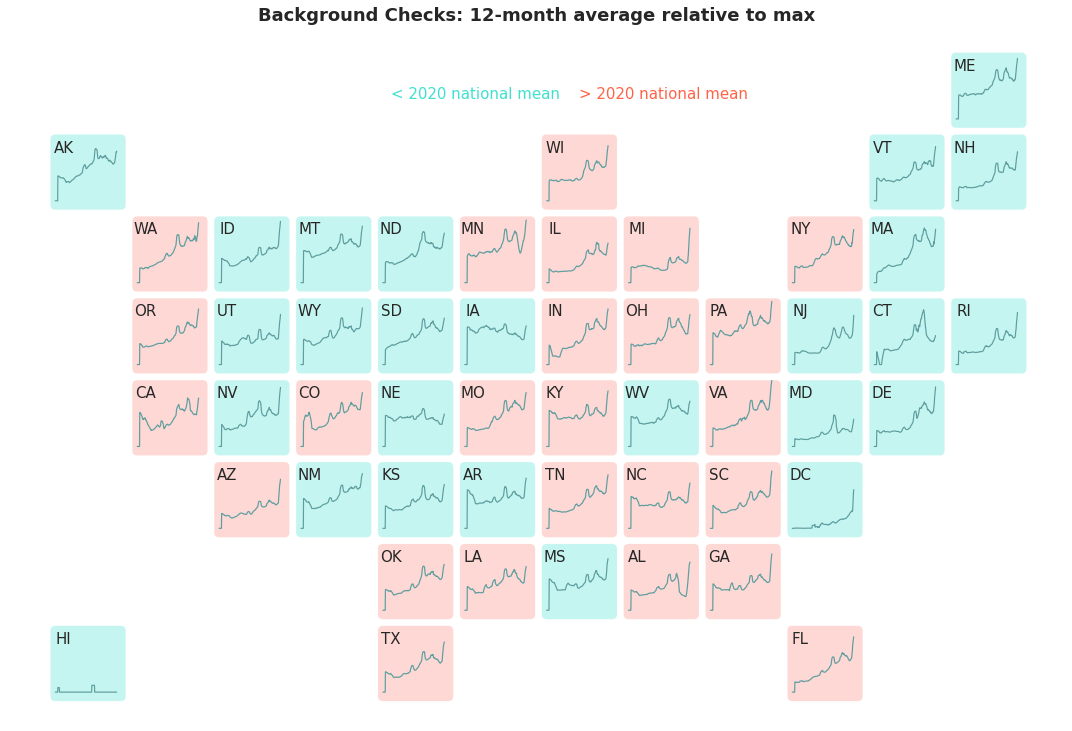

In [210]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.FancyBboxPatch.html

fig, ax = plt.subplots(1, figsize=(15, 21))
ax.set_aspect(1.)
ax.invert_yaxis()

patches = []
color_list = []

x = np.linspace(0., 0.75, states_total_checks.shape[0])

for state in states_total_checks.columns:
    monthly = states_total_checks[state]
    
    timeline = (monthly.rolling(12).mean()/monthly.max()).fillna(0).values
    
    if monthly[-1] > mean_checks:
        color = 'salmon'
    elif monthly[-1] < mean_checks:
        color = 'turquoise'
    
    fancybox = mpatches.FancyBboxPatch([state_patches.x[state]-0.5, 
                                        state_patches.y[state]-0.5], 
                                        0.8, 
                                        0.8,
                                        boxstyle=mpatches.BoxStyle("Round", pad=0.06))
    patches.append(fancybox)
    color_list.append(color)
    
    ax.text(y=state_patches.y[state]-0.4, x=state_patches.x[state]-0.4, 
            s=state_patches.loc[state, 'index'], horizontalalignment='center', verticalalignment='center', fontsize=15)
   
    ax.plot(state_patches.x[state]+x-0.5, state_patches.y[state]-timeline+0.25, lw=1.2, color='cadetblue')

collection = PatchCollection(patches, facecolors=color_list, alpha=0.3)
ax.add_collection(collection)

ax.set_title('Background Checks: 12-month average relative to max', fontweight='bold',size=18)
ax.text(x=3.6, y=0, s='< 2020 national mean', color='turquoise', fontsize=15, ha='left')
ax.text(x=5.9, y=0, s='> 2020 national mean', color='tomato', fontsize=15, ha='left')

ax.axis('off')
fig.patch.set_facecolor('white')
fig.tight_layout()

#plt.savefig(f'../gun_sales_time_series/boxpatch.png', dpi=400, bbox_inches='tight')

## 5.2. National Gun Sales

In [211]:
# Compute sales using multiplier of 1.1 for handguns and long guns and 2 for multiple guns (discussed in the intro)
guns = guns.assign(
        handgun_sales = (guns['handgun_checks'] * 1.1).astype(int),
        long_gun_sales = (guns['long_gun_checks'] * 1.1).astype(int),
        multiple_gun_sales = (guns['multiple_gun_checks'] * 2).astype(int))

guns['total_sales'] = (guns.handgun_sales + guns.long_gun_sales + guns.multiple_gun_sales).astype(int)

# Check first few rows
guns.head()

month_stamp          state  handgun_checks  long_gun_checks  \
0  1999-01-01        Wyoming             668             1401   
1  1999-01-01      Wisconsin            2709             5063   
2  1999-01-01  West Virginia            2989             5118   
3  1999-01-01     Washington            1891             5780   
4  1999-01-01       Virginia            6298             7556   

   multiple_gun_checks  total_checks  handgun_sales  long_gun_sales  \
0                   44          2113            734            1541   
1                    8          7780           2979            5569   
2                  153          8260           3287            5629   
3                  149          7820           2080            6358   
4                  127         13981           6927            8311   

   multiple_gun_sales  total_sales  
0                  88         2363  
1                  16         8564  
2                 306         9222  
3                 298         8736  
4                 254        15492

In [212]:
# National handgun sales 
national_handgun_sales = pd.DataFrame(guns.groupby('month_stamp')['handgun_sales'].sum())

# National long gun sales 
national_long_gun_sales = pd.DataFrame(guns.groupby('month_stamp')['long_gun_sales'].sum())

# National multiple gun sales 
national_mult_gun_sales = pd.DataFrame(guns.groupby('month_stamp')['multiple_gun_sales'].sum())

# National total sales 
national_total_sales = pd.DataFrame(guns.groupby('month_stamp')['total_sales'].sum())

# National sales dataframe
national_sales = pd.concat([national_handgun_sales, national_long_gun_sales, national_mult_gun_sales, national_total_sales], axis=1)

national_sales.reset_index(inplace=True)
#national_sales['month_stamp'] = national_sales['month_stamp'].dt.to_timestamp()
national_sales.set_index('month_stamp', inplace=True)

# Check last few rows
national_sales.tail()

handgun_sales  long_gun_sales  multiple_gun_sales  total_sales
month_stamp                                                                
2020-07-01         1229997          613080               66680      1909757
2020-08-01         1043882          636813               56554      1737249
2020-09-01          965130          659239               54954      1679323
2020-10-01         1025102          732860               59406      1817368
2020-11-01         1069358          880891               69646      2019895

## 5.2.1. Observed

Text(2020-01-30 00:00:00, 2519232, '1st covid case')

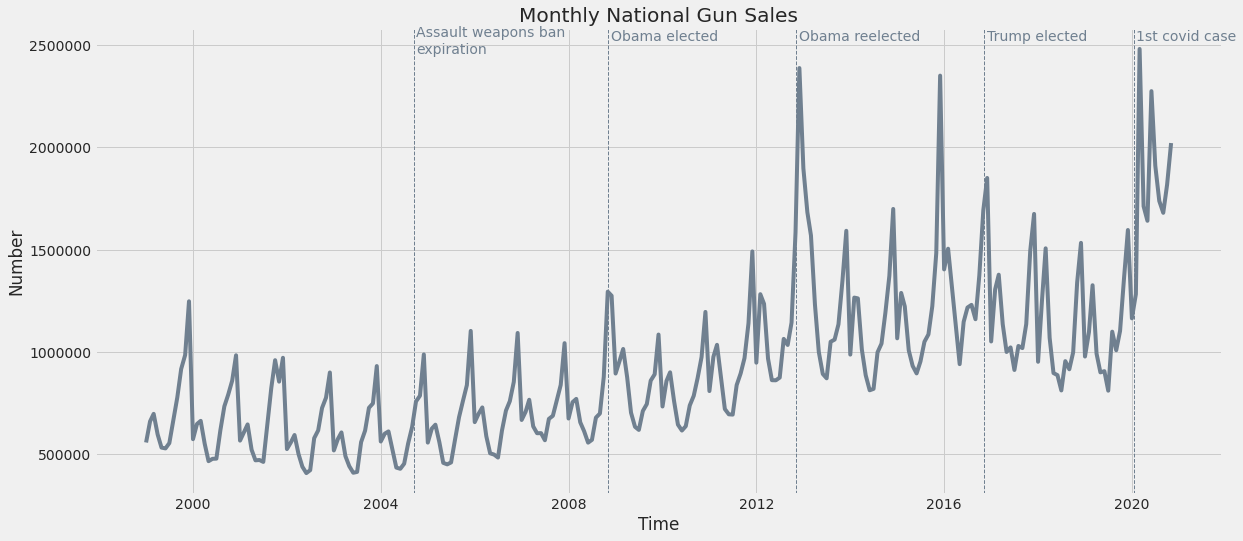

In [213]:
# Plot national total sales
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))

sns.lineplot(x=national_sales.index, 
             y='total_sales', 
             data=national_sales, 
             color='slategray',
             ax=ax)


ax.set(title='Monthly National Gun Sales', xlabel='Time', ylabel='Number')
ax.ticklabel_format(style='plain', axis='y') #Removes scientific notation (e.g., e^6 on y axis)

ax.axvline(pd.to_datetime('2004-09-13'), ymax=1500000, color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2004-09-30'), max(national_sales['total_sales'])-20000, 'Assault weapons ban\nexpiration', color='slategray')

ax.axvline(pd.to_datetime('2008-11-04'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2008-11-30'), max(national_sales['total_sales'])+40000, 'Obama elected', color='slategray')

ax.axvline(pd.to_datetime('2012-11-06'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2012-11-30'), max(national_sales['total_sales'])+40000, 'Obama reelected', color='slategray')

ax.axvline(pd.to_datetime('2016-11-08'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2016-11-30'), max(national_sales['total_sales'])+40000, 'Trump elected', color='slategray')

ax.axvline(pd.to_datetime('2020-01-20'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2020-01-30'), max(national_sales['total_sales'])+40000, '1st covid case', color='slategray')

#plt.savefig(f'../gun_sales_time_series/gun_sales.png', dpi=400, bbox_inches='tight')

- Clear seasonal trend with a spike every year around December
- Seasonality itself is increasing since around 2008 (multiplicative) 
- Positive upward trend
- Seems to be a structural upward shift starting 2012 

## 5.2.2 Rolling mean with rolling standard deviation

Text(2020-01-30 00:00:00, 2519232, '1st covid case')

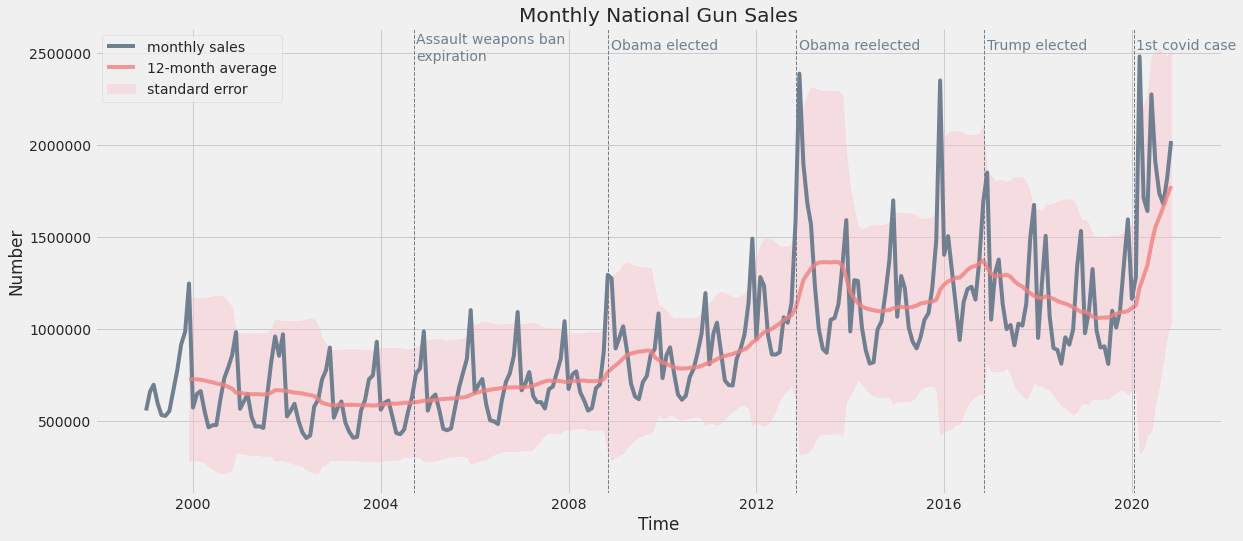

In [214]:
# Plot national total sales
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=national_sales.index, y='total_sales', data=national_sales, color='slategray',ax=ax, label='monthly sales')

rolling_national_sales = national_sales.rolling(12).mean()
sns.lineplot(x=national_sales.index, 
             y='total_sales', 
             data=rolling_national_sales, 
             color='lightcoral',
             ax=ax, 
             label='12-month average', 
             alpha=0.8)

rolling_std = national_sales['total_sales'].rolling(12).std().to_frame()
ax.fill_between(national_sales.index, 
                rolling_national_sales['total_sales'] + (2 * rolling_std['total_sales']), 
                rolling_national_sales['total_sales'] - (2 * rolling_std['total_sales']), 
                color='pink', alpha=0.4, 
                label="standard error")

ax.set(title='Monthly National Gun Sales', xlabel='Time', ylabel='Number')
ax.ticklabel_format(style='plain', axis='y') #Removes scientific notation (e.g., e^6 on y axis)
ax.legend()

ax.axvline(pd.to_datetime('2004-09-13'), ymax=1500000, color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2004-09-30'), max(national_sales['total_sales'])-20000, 'Assault weapons ban\nexpiration', color='slategray')

ax.axvline(pd.to_datetime('2008-11-04'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2008-11-30'), max(national_sales['total_sales'])+40000, 'Obama elected', color='slategray')

ax.axvline(pd.to_datetime('2012-11-06'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2012-11-30'), max(national_sales['total_sales'])+40000, 'Obama reelected', color='slategray')

ax.axvline(pd.to_datetime('2016-11-08'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2016-11-30'), max(national_sales['total_sales'])+40000, 'Trump elected', color='slategray')

ax.axvline(pd.to_datetime('2020-01-20'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2020-01-30'), max(national_sales['total_sales'])+40000, '1st covid case', color='slategray')

#plt.savefig(f'../gun_sales_time_series/gun_sales_se.png', dpi=400, bbox_inches='tight')

Smoothing out the data by taking the rolling 12-month average, we see a clear upward trend with a particular strong uptick in 2020. 

Looking at the standard deviation, variablity also seems to be increasing with time.



We used moving average of 12 units to reflect the yearly structure of the data.
The orange line is capturing overarching trend of positive increase over time
Then the remaining question is, how much of those cyclic up & down movements in the data can be explained by the 12-month structure in the data? In other words, can we separate out the variation due to seasonality from this global trend?

## 5.2.3 Rolling median with rolling quantiles

Text(2020-01-30 00:00:00, 2519232, '1st covid case')

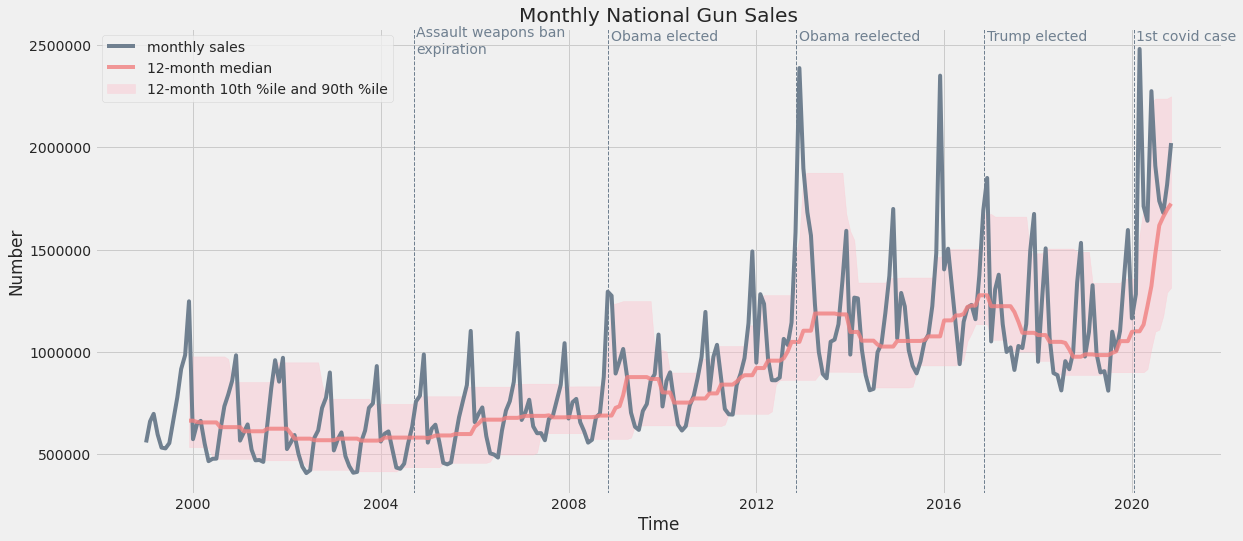

In [215]:
# Plot national total sales
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=national_sales.index, y='total_sales', data=national_sales, color='slategray',ax=ax, label='monthly sales')

q10 = national_sales['total_sales'].rolling(12).quantile(.10).to_frame()
median = national_sales.rolling(12).median()
q90 = national_sales['total_sales'].rolling(12).quantile(.90).to_frame()

sns.lineplot(x=national_sales.index, 
             y='total_sales', 
             data=median, 
             color='lightcoral',
             ax=ax, 
             label='12-month median', 
             alpha=0.8)

rolling_std = national_sales['total_sales'].rolling(12).std().to_frame()
ax.fill_between(national_sales.index, 
                q10['total_sales'], 
                q90['total_sales'], 
                color='pink', alpha=0.4, 
                label="12-month 10th %ile and 90th %ile")

ax.set(title='Monthly National Gun Sales', xlabel='Time', ylabel='Number')
ax.ticklabel_format(style='plain', axis='y') #Removes scientific notation (e.g., e^6 on y axis)
ax.legend()

ax.axvline(pd.to_datetime('2004-09-13'), ymax=1500000, color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2004-09-30'), max(national_sales['total_sales'])-20000, 'Assault weapons ban\nexpiration', color='slategray')

ax.axvline(pd.to_datetime('2008-11-04'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2008-11-30'), max(national_sales['total_sales'])+40000, 'Obama elected', color='slategray')

ax.axvline(pd.to_datetime('2012-11-06'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2012-11-30'), max(national_sales['total_sales'])+40000, 'Obama reelected', color='slategray')

ax.axvline(pd.to_datetime('2016-11-08'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2016-11-30'), max(national_sales['total_sales'])+40000, 'Trump elected', color='slategray')

ax.axvline(pd.to_datetime('2020-01-20'), color='slategray', lw=1, linestyle='--')
ax.text(pd.to_datetime('2020-01-30'), max(national_sales['total_sales'])+40000, '1st covid case', color='slategray')

#plt.savefig(f'../gun_sales_time_series/gun_sales_quantiles.png', dpi=400, bbox_inches='tight')

Similatly, taking the rolling 12-month median, we see a clear upward trend with a particular strong uptick in 2020. 

The range between the 10th percentile and 90th percentile also seems to be increasing. 

## 5.3. Population-Adjusted National Sales

Since population, specifically the population over age 18 legally allowed to buy guns, has increased over the time period, we can get to a more accurate picture by adjusting national sales for population. Let's pull monthly U.S. population estimates from [Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/), calculate the population over age 18, which has remained roughly 75% of the total population throughout the time period. We can then calculate sales per 100000 by dividing sales by the population over age 18 and multiplying by 100000. 

In [216]:
# Monthly U.S. population in '000s

# Set start date as January 1, 1990
start = date(1999, 1, 1)

# Set series code, can find on FRED website
series = 'POPTHM'

# Import the data, multiply by 1000 as the data is in '000s
population = DataReader(series, 'fred', start=start) * 1000

# Check first 2 and last 2 rows. 
pd.concat([population.head(2), population.tail(2)])

POPTHM
DATE                   
1999-01-01  277891000.0
1999-02-01  278095000.0
2020-09-01  330535000.0
2020-10-01  330692000.0

In [217]:
# It's not exactly in the form we need, so let's adjust it. Population for November 2020 is missing so let's add that.  

# Reset index
population.reset_index(inplace=True)

# Rename columns
population.columns = ['month_stamp', 'total_pop']
                    
# Set data types
population['month_stamp'] = population['month_stamp'].astype(str)
population['total_pop'] = population['total_pop'].astype(int)

# Add in population for Nov 2020 as new row
nov_2020_pop = ((population.iloc[-1,1] / population.iloc[-2,1]) * population.iloc[-1,1]).astype(int) # Multiply previous month by growth rate of previous month
df2 = pd.DataFrame([['2020-11-01',nov_2020_pop]], columns=['month_stamp','total_pop'])
population = pd.concat([population, df2], ignore_index=True)

# Convert month_stamp to datetime type
population['month_stamp'] = pd.to_datetime(population['month_stamp'])

# Set index to month_stamp
population.set_index('month_stamp', inplace=True)

# Calculate population over 18 as 0.75 * population (population over 18 is roughly 75% of population over the years)
population['pop_over_18'] = (population['total_pop']*0.75).astype(int)

# Check first 3 and last 3 rows. We see that it's monthly data starting at the 1st of each month
pd.concat([population.head(3), population.tail(3)])

total_pop  pop_over_18
month_stamp                        
1999-01-01   277891000    208418250
1999-02-01   278095000    208571250
1999-03-01   278324000    208743000
2020-09-01   330535000    247901250
2020-10-01   330692000    248019000
2020-11-01   330849074    248136805

As we can see the population increased from about 278 million in December 1998 to about 331 million in November 2020. The percent of the population over age 18 has remained roughly consistently 75% over this time and has grown from about 208 million in December 1998 to 248 million in November 2020. The population over 18 which is legally allowed to buy guns is the relevant figure for our case. 

In [218]:
# Check info, data type of dataframe
population.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263 entries, 1999-01-01 to 2020-11-01
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_pop    263 non-null    int64
 1   pop_over_18  263 non-null    int64
dtypes: int64(2)
memory usage: 6.2 KB


In [219]:
# Combine national sales and population dataframes
national_sales = pd.concat([national_sales.reset_index(), population.reset_index(drop=True)], axis=1)

In [220]:
# Compute sales per 100000 by dividing sales by population over 18 and multiplying by 100000
national_sales = national_sales.assign(
                                       handgun_sales_per_100000 = ((national_sales['handgun_sales'] / national_sales['pop_over_18'])*100000).astype(int),
                                       long_gun_sales_per_100000 = ((national_sales['long_gun_sales'] / national_sales['pop_over_18'])*100000).astype(int),
                                       multiple_gun_sales_per_100000 = ((national_sales['multiple_gun_sales'] / national_sales['pop_over_18'])*100000).astype(int),
                                       total_sales_per_100000 = ((national_sales['total_sales'] / national_sales['pop_over_18'])*100000).astype(int)
                                      )

national_sales.set_index('month_stamp', inplace=True)

national_sales.head()

handgun_sales  long_gun_sales  multiple_gun_sales  total_sales  \
month_stamp                                                                   
1999-01-01          202589          340780               14988       558357   
1999-02-01          255368          387557               18442       661367   
1999-03-01          264727          414334               19058       698119   
1999-04-01          227446          355456               14674       597576   
1999-05-01          210816          309472               13182       533470   

             total_pop  pop_over_18  handgun_sales_per_100000  \
month_stamp                                                     
1999-01-01   277891000    208418250                        97   
1999-02-01   278095000    208571250                       122   
1999-03-01   278324000    208743000                       126   
1999-04-01   278584000    208938000                       108   
1999-05-01   278859000    209144250                       100   

             long_gun_sales_per_100000  multiple_gun_sales_per_100000  \
month_stamp                                                             
1999-01-01                         163                              7   
1999-02-01                         185                              8   
1999-03-01                         198                              9   
1999-04-01                         170                              7   
1999-05-01                         147                              6   

             total_sales_per_100000  
month_stamp                          
1999-01-01                      267  
1999-02-01                      317  
1999-03-01                      334  
1999-04-01                      286  
1999-05-01                      255

## 5.3.1. Rolling Mean with Rolling Standard Deviation

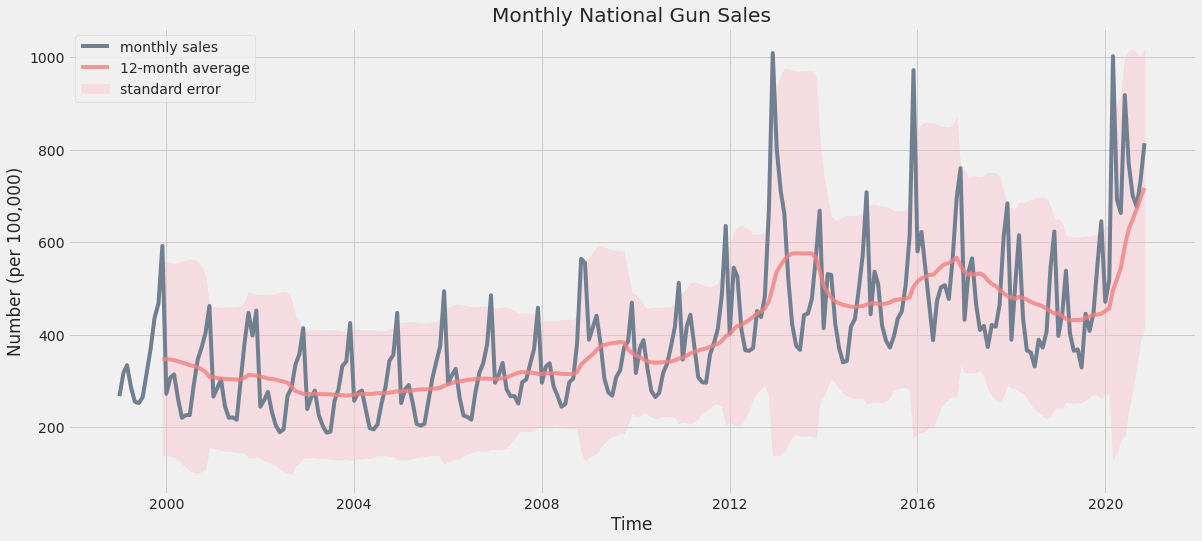

In [221]:
# Plot national total sales
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=national_sales.index, y='total_sales_per_100000', data=national_sales, color='slategray',ax=ax, label='monthly sales')

rolling_national_sales = national_sales.rolling(12).mean()
sns.lineplot(x=national_sales.index, 
             y='total_sales_per_100000', 
             data=rolling_national_sales, 
             color='lightcoral',
             ax=ax, 
             label='12-month average', 
             alpha=0.8)

rolling_std = national_sales['total_sales_per_100000'].rolling(12).std().to_frame()
ax.fill_between(national_sales.index, 
                rolling_national_sales['total_sales_per_100000'] + (2 * rolling_std['total_sales_per_100000']), 
                rolling_national_sales['total_sales_per_100000'] - (2 * rolling_std['total_sales_per_100000']), 
                color='pink', alpha=0.4, 
                label="standard error")

ax.set(title='Monthly National Gun Sales', xlabel='Time', ylabel='Number (per 100,000)')
ax.legend()

#plt.savefig(f'../gun_sales_time_series/gun_sales_per_100000.png', dpi=400, bbox_inches='tight')

- Clear seasonal trend with a spike every year around December
- Seasonality itsef is increasing since around 2008 (multiplicative) 
- The smoothed data showing the rolling 12-month average in red shows a clear positive upward trend, with a particular strong uptick in 2020. 
- Seems to be a structural upward shift starting 2012 
- Looking at the standard deviation, variablity also seems to be increasing with time

## 5.3.2. Monthly Sales by Year

In [149]:
# Create separate month and year columns so we can plot seasonality by year and month
national_sales.reset_index(inplace=True)

national_sales = national_sales.assign(year = lambda x: x['month_stamp'].dt.year,
                                       month = lambda x: x['month_stamp'].dt.month)

                                   
# Check first few rows
national_sales.head()

month_stamp  handgun_sales  long_gun_sales  multiple_gun_sales  total_sales  \
0  1999-01-01         202589          340780               14988       558357   
1  1999-02-01         255368          387557               18442       661367   
2  1999-03-01         264727          414334               19058       698119   
3  1999-04-01         227446          355456               14674       597576   
4  1999-05-01         210816          309472               13182       533470   

   total_pop  pop_over_18  handgun_sales_per_100000  \
0  277891000    208418250                        97   
1  278095000    208571250                       122   
2  278324000    208743000                       126   
3  278584000    208938000                       108   
4  278859000    209144250                       100   

   long_gun_sales_per_100000  multiple_gun_sales_per_100000  \
0                        163                              7   
1                        185                              8   
2                        198                              9   
3                        170                              7   
4                        147                              6   

   total_sales_per_100000  year  month  
0                     267  1999      1  
1                     317  1999      2  
2                     334  1999      3  
3                     286  1999      4  
4                     255  1999      5

In [150]:
# Check dataframe info
national_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   month_stamp                    263 non-null    datetime64[ns]
 1   handgun_sales                  263 non-null    int64         
 2   long_gun_sales                 263 non-null    int64         
 3   multiple_gun_sales             263 non-null    int64         
 4   total_sales                    263 non-null    int64         
 5   total_pop                      263 non-null    int64         
 6   pop_over_18                    263 non-null    int64         
 7   handgun_sales_per_100000       263 non-null    int64         
 8   long_gun_sales_per_100000      263 non-null    int64         
 9   multiple_gun_sales_per_100000  263 non-null    int64         
 10  total_sales_per_100000         263 non-null    int64         
 11  year               

[Text(0, 0.5, 'Number (per 100,000)'),
 Text(0.5, 1.0, 'Monthly Gun Sales by Year')]

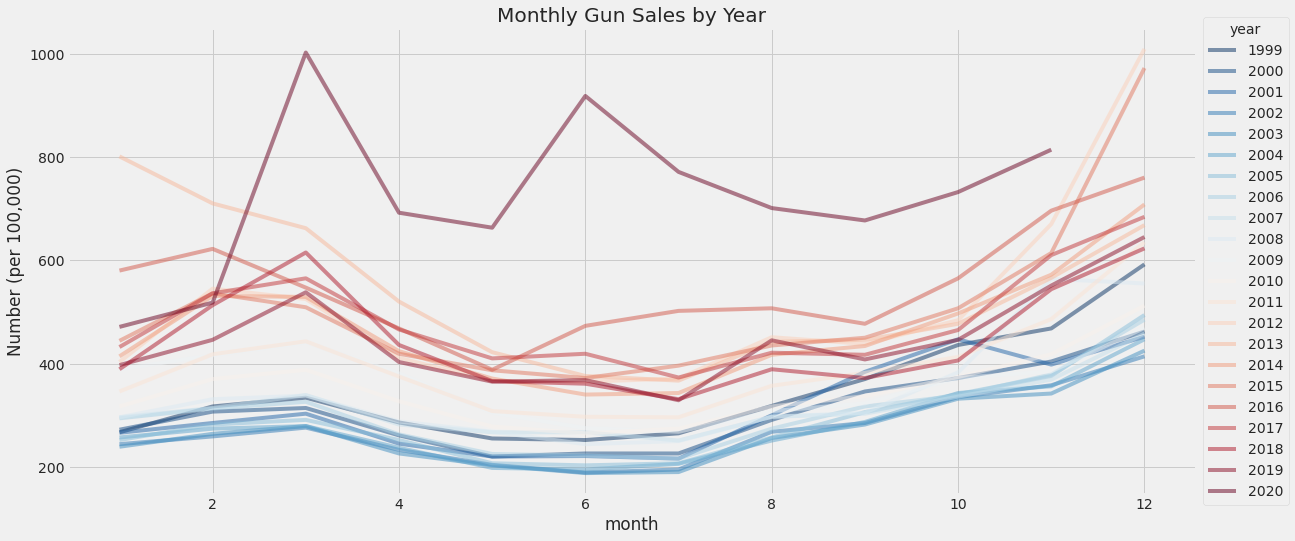

In [151]:
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))

pd.pivot_table(data=national_sales[['year', 'month', 'total_sales_per_100000']], index='month', columns='year')['total_sales_per_100000'].plot(cmap='RdBu_r', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Monthly Gun Sales by Year', ylabel='Number (per 100,000)')
#plt.savefig(f'../gun_sales_time_series/gun_sales_by_year.png', dpi=400, bbox_inches='tight')

By stratifying the lineplot by year, the seasonality in each year and the dramatic shift upward in overall gun sales becomes more visible.

2020 and the past few years (in the dark reds) have levels of gun sales that, in some months (e.g., March 2020), are 4-5x higher than that of the same month in the late '90s and early 2000s. 
The 3 highest monthly sales occurred in March 2020, December 2012, and December 2015.

Interestingly, gun sales generally trend upward in November and December of each year and lag in the summer months, except in 2020, when gun sales saw a spike in March and in June and have generally been nearly at the November and December highs of previous years. 

In [152]:
# Statistical summary of total sales per 100,000 by year
pd.pivot_table(data=national_sales[['year', 'month', 'total_sales_per_100000']], index='month', columns='year')['total_sales_per_100000'].describe()

year         1999        2000        2001        2002        2003        2004  \
count   12.000000   12.000000   12.000000   12.000000   12.000000   12.000000   
mean   346.666667  308.416667  311.416667  271.666667  268.833333  277.500000   
std    104.167115   75.974228   87.345144   68.519849   70.067284   74.032548   
min    252.000000  220.000000  216.000000  189.000000  188.000000  195.000000   
25%    266.500000  252.250000  239.000000  225.750000  220.250000  229.250000   
50%    317.500000  299.000000  292.500000  263.500000  260.000000  265.500000   
75%    386.500000  352.500000  387.500000  297.500000  294.500000  301.000000   
max    592.000000  462.000000  452.000000  414.000000  425.000000  447.000000   

year         2005        2006        2007        2008        2009        2010  \
count   12.000000   12.000000   12.000000   12.000000   12.000000   12.000000   
mean   289.000000  304.333333  314.916667  343.250000  361.000000  348.083333   
std     83.799544   76.076915   56.411569  108.049757   64.950331   70.262441   
min    203.000000  216.000000  251.000000  244.000000  268.000000  265.000000   
25%    240.750000  253.500000  278.250000  283.000000  307.250000  307.250000   
50%    269.500000  303.500000  300.000000  301.000000  376.500000  332.000000   
75%    314.750000  329.000000  336.750000  349.250000  395.750000  377.500000   
max    494.000000  485.000000  458.000000  564.000000  469.000000  512.000000   

year         2011         2012        2013        2014        2015  \
count   12.000000    12.000000   12.000000   12.000000   12.000000   
mean   396.333333   503.166667  538.083333  465.000000  503.416667   
std     95.538981   182.697879  142.215878  107.393076  163.333712   
min    296.000000   365.000000  367.000000  340.000000  372.000000   
25%    336.500000   395.000000  437.000000  403.250000  413.250000   
50%    378.500000   444.500000  498.500000  429.000000  447.000000   
75%    424.250000   530.000000  663.500000  529.500000  515.750000   
max    635.000000  1009.000000  801.000000  708.000000  972.000000   

year         2016        2017        2018        2019         2020  
count   12.000000   12.000000   12.000000   12.000000    11.000000  
mean   548.750000  483.166667  445.416667  445.083333   723.545455  
std    104.487603   94.869128  102.026252   91.008949   154.666974  
min    388.000000  373.000000  331.000000  329.000000   471.000000  
25%    476.000000  418.500000  370.500000  389.750000   670.000000  
50%    527.000000  448.500000  397.500000  426.500000   701.000000  
75%    590.500000  543.250000  520.750000  469.000000   792.500000  
max    760.000000  684.000000  623.000000  645.000000  1002.000000

## 5.3.3. Monthly Cyclic Sales by Year

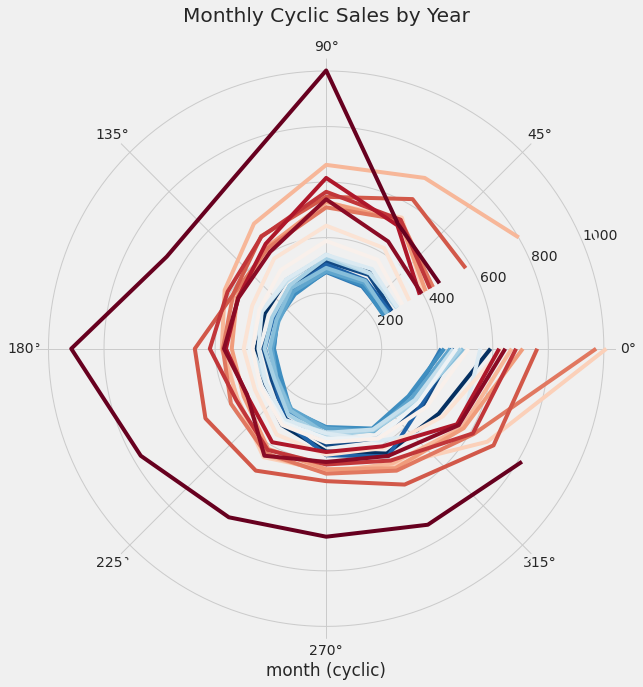

In [153]:
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,10))

ax = plt.subplot(111, projection='polar')

national_sales.assign(month_cyclic = lambda x: x['month'].transform(lambda x: 2*np.pi*x/12)).pipe((sns.lineplot, 'data'), x='month_cyclic', y='total_sales_per_100000', hue='year',ax=ax, palette='RdBu_r')
                                      
ax.set(title='Monthly Cyclic Sales by Year', ylabel='', xlabel='month (cyclic)')
ax.get_legend().set_visible(False) # The legend labels were not showing up properly, I couldn't fix it, so I set it to False here for the meantime
#plt.savefig(f'../gun_sales_time_series/gun_sales_polar.png', dpi=400, bbox_inches='tight')

A polar plot reveals the structural uptick in gun sales in recent years compared to the late '90s and early 2000s. 2020 in the dark red on the outside shows an especially strong upward shift. The highest gun sales in the period occured in March 2020 (dark read peak at the top of the circle).

## 5.3.4. Monthly Sales Yearly Seasonality 

Text(0.5, 1.01, 'Monthly Sales - Yearly Seasonality')

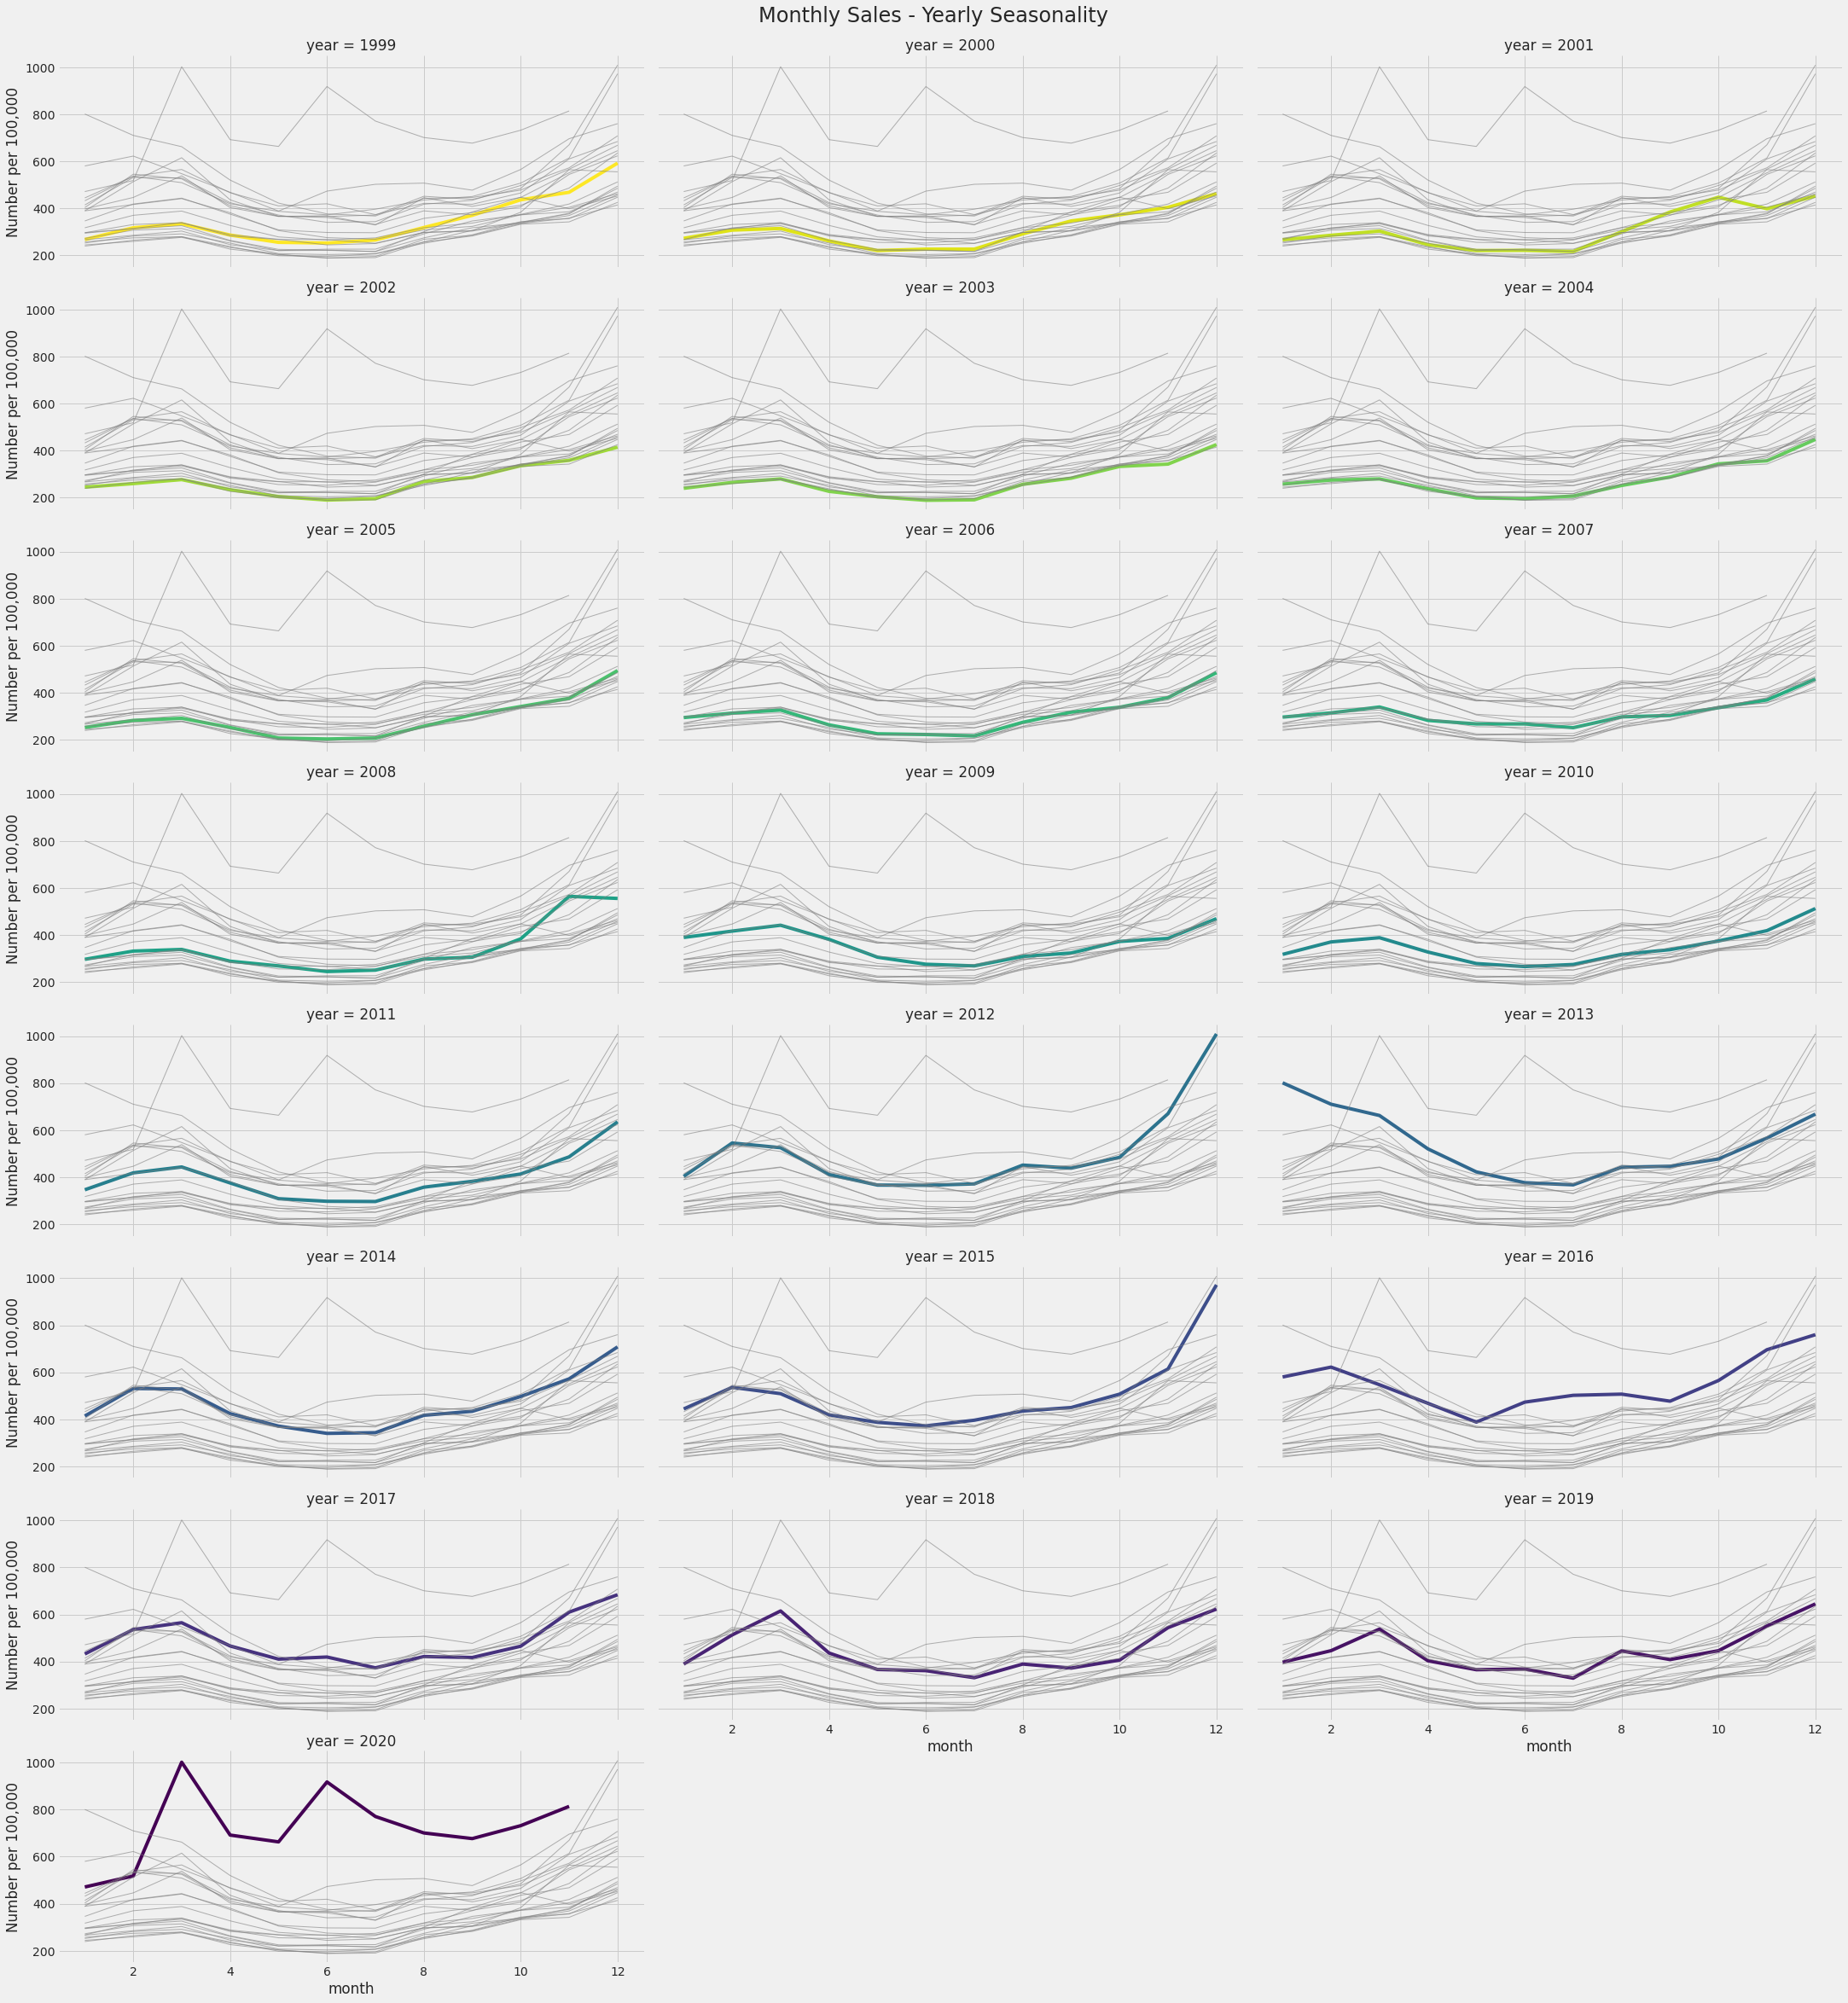

In [154]:
style.use('fivethirtyeight')
g = sns.relplot(data=national_sales,
                x='month', 
                y='total_sales_per_100000', 
                col='year', 
                hue='year',
                palette='viridis_r',
                kind='line', 
                estimator=None,
                col_wrap=3, 
                height=4, 
                aspect=2.5, 
                legend=False
               )

for year, ax in g.axes_dict.items():
    sns.lineplot(x='month', 
                 y='total_sales_per_100000', 
                 data=national_sales.query(f'year != {year}'),
                 units='year',
                 estimator=None, 
                 color='gray', 
                 alpha=0.6,
                 linewidth=1, 
                 ax=ax
                )

g.set_axis_labels('month', 'Number per 100,000')
g.fig.suptitle('Monthly Sales - Yearly Seasonality', fontsize=24, y=1.01)
#plt.savefig(f'../gun_sales_time_series/sales_by_year_line_facet.png', dpi=400, bbox_inches='tight')

## 5.3.5. Distribution of Monthly Sales by Year 

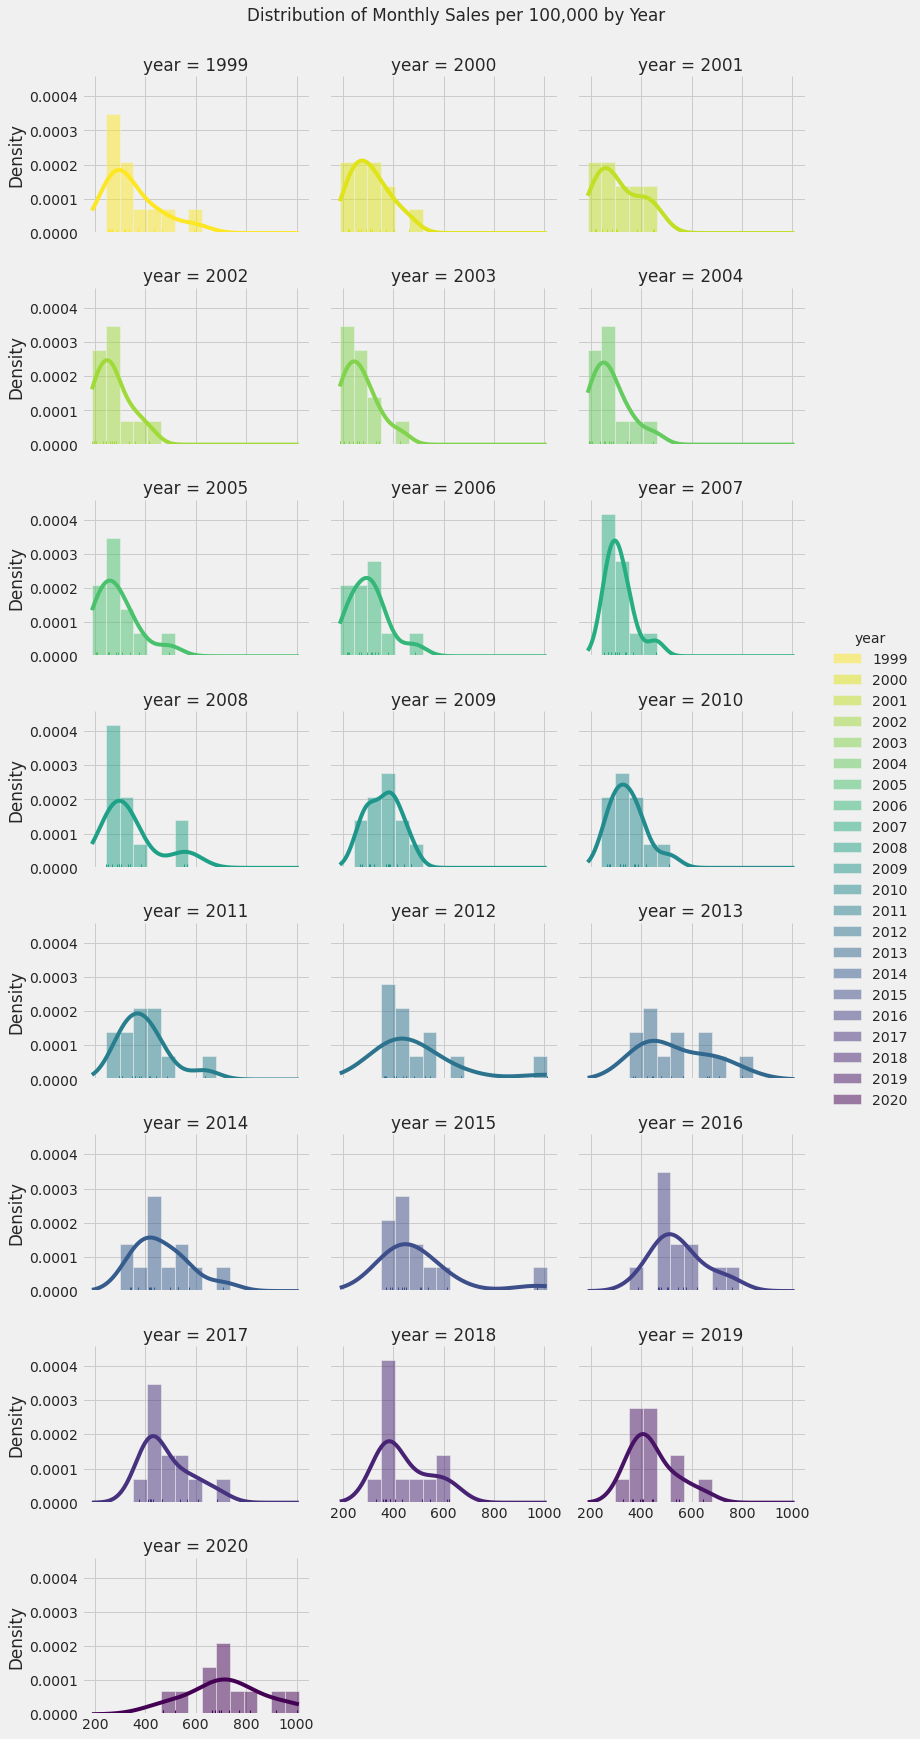

In [155]:
g = sns.displot(
    x='total_sales_per_100000',
    data=national_sales,
    rug=True,
    kde=True,
    stat='density',
    col='year',
    col_wrap=3,
    hue='year',
    height=3,
    aspect=1.3,
    palette='viridis_r'
)

g.fig.suptitle('Distribution of Monthly Sales per 100,000 by Year', y=1.02)
g.set_axis_labels(x_var="")
#plt.savefig(f'../gun_sales_time_series/distribution_by_year.png', dpi=400, bbox_inches='tight')

The distributions start right-skewed with the mean increasing over the years. Beginning in 2012, the distributions becomes wider and more dispersed so much so that by 2020, the distribution is almost unrecognizeable from that of 1999. 

## 5.3.6. Monthly Sales by Year Bar

[Text(0, 0.5, 'Number (per 100,000)'), Text(0.5, 1.0, 'Monthly Gun Sales')]

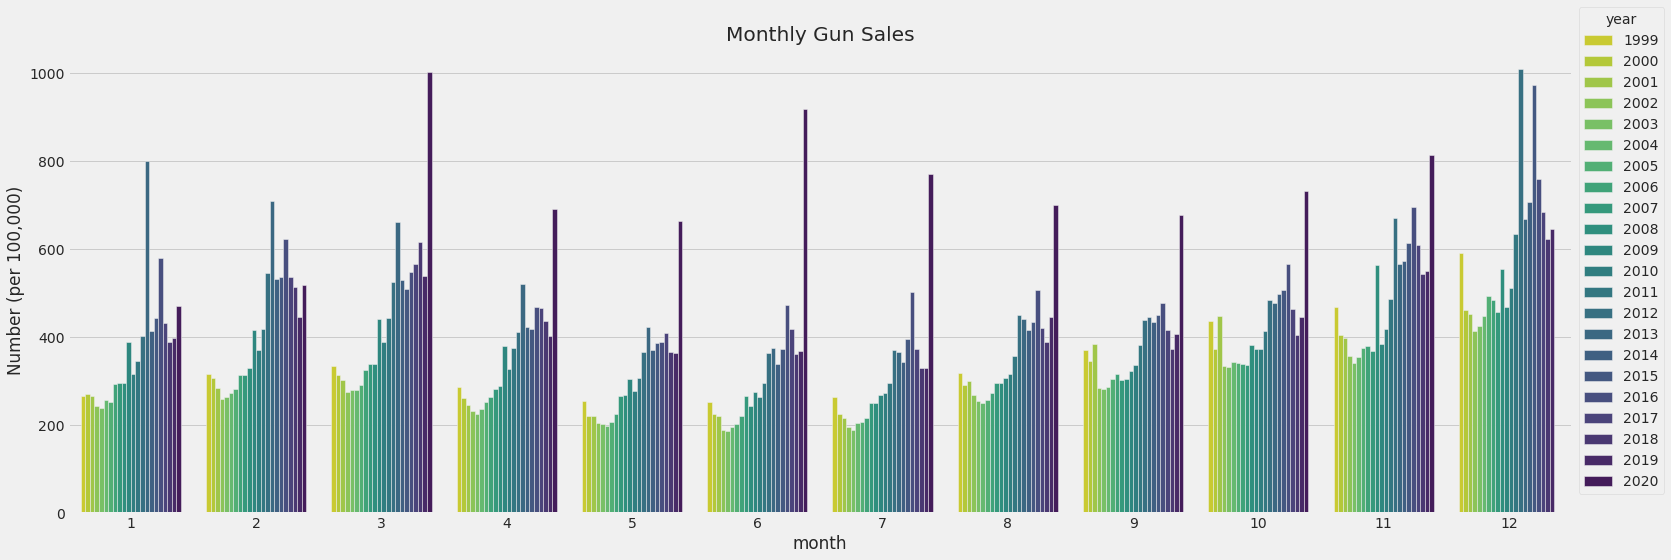

In [156]:
fig, ax = plt.subplots(figsize=(24,8))

national_sales.groupby(['year', 'month'], as_index=False) \
              .agg({'total_sales_per_100000': np.sum}) \
              .pipe((sns.barplot, 'data'), x='month', y='total_sales_per_100000', hue='year',palette='viridis_r', ax=ax)

ax.legend(title='year', loc='upper left', bbox_to_anchor=(1, 1.1))
ax.set(title='Monthly Gun Sales', ylabel='Number (per 100,000)')
#plt.savefig(f'../gun_sales_time_series/sales_bar_by_year.png', dpi=400, bbox_inches='tight')

## 5.3.7. YoY Monthly Sales Growth 

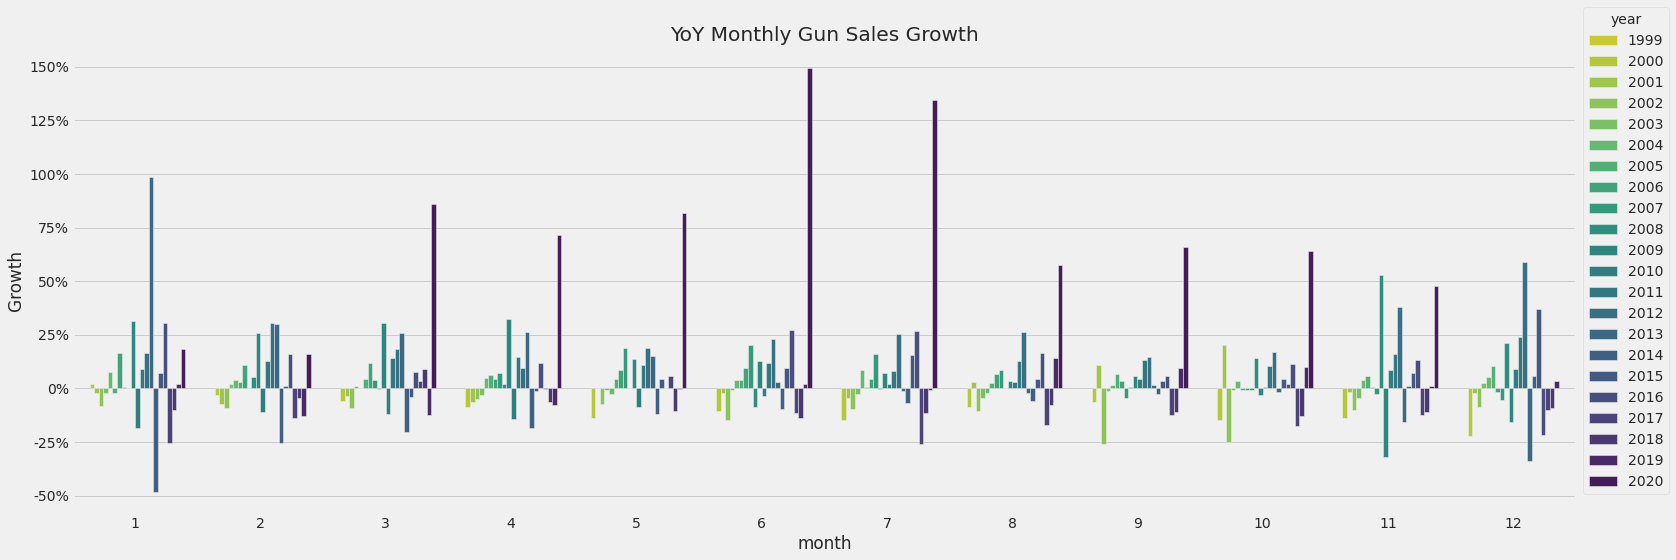

In [157]:
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(24,8))

national_sales.groupby(['year', 'month'], as_index=False) \
              .agg({'total_sales_per_100000': np.sum}) \
              .sort_values(['month', 'year']) \
              .assign(sales_lag = lambda x: x.groupby('month')['total_sales_per_100000'].transform('shift'), 
                      yoy_monthly_growth = lambda x: x['total_sales_per_100000'].div(x['sales_lag']) - 1
                      ) \
              .pipe((sns.barplot, 'data'), 
                     x='month', 
                     y='yoy_monthly_growth', 
                     hue='year', 
                     palette = 'viridis_r',
                     ax=ax
                     )

ax.legend(title='year', loc='upper left', bbox_to_anchor=(1, 1.1))
ax.set(title='YoY Monthly Gun Sales Growth', ylabel='Growth')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
#plt.savefig(f'../gun_sales_time_series/yoy_sales_growth_bar.png', dpi=400, bbox_inches='tight')

## 5.3.8. YoY Monthly Sales Share Growth 

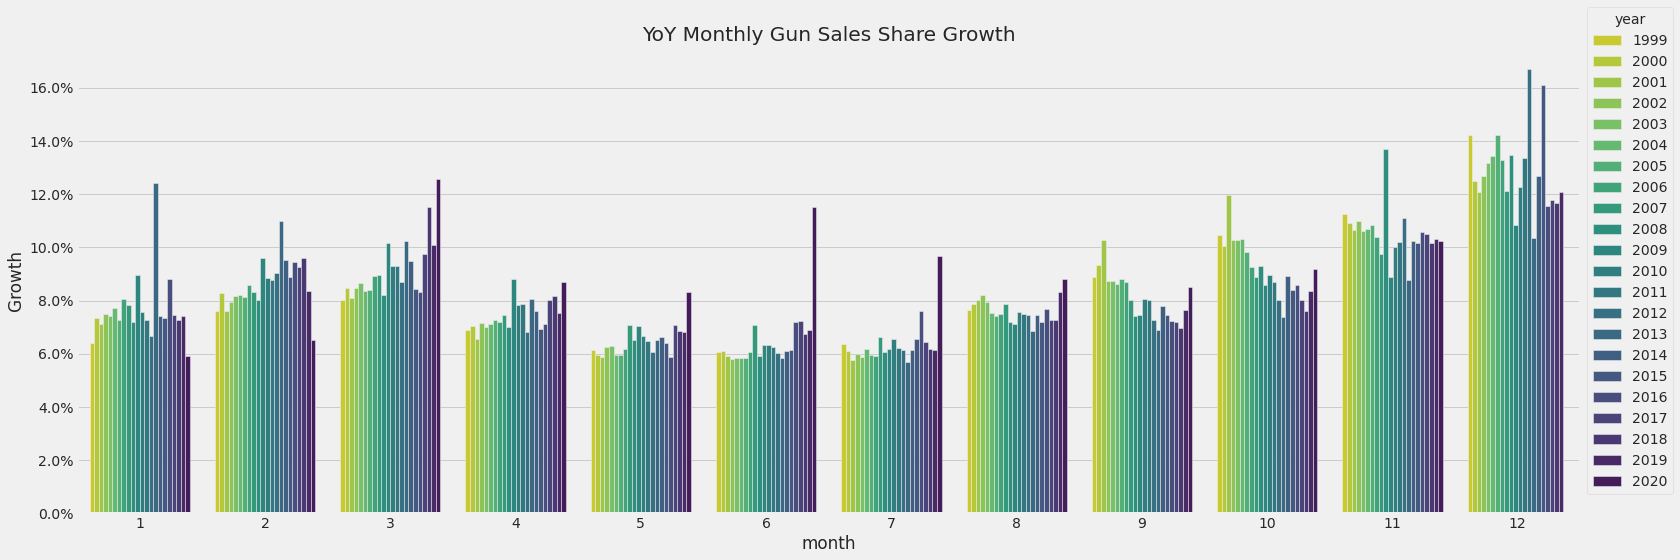

In [158]:
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(24,8))

national_sales.groupby(['year', 'month'], as_index=False) \
              .agg({'total_sales_per_100000': np.sum}) \
              .assign(yearly_sales = lambda x: x.groupby('year')['total_sales_per_100000'].transform(np.sum), 
                      montly_sales_share = lambda x: x['total_sales_per_100000'].div(x['yearly_sales'])
                     ) \
              .pipe((sns.barplot, 'data'), 
                     x='month', 
                     y='montly_sales_share', 
                     hue='year',
                     palette = 'viridis_r',
                     ax=ax
                   )

ax.legend(title='year', loc='upper left', bbox_to_anchor=(1, 1.1))
ax.set(title='YoY Monthly Gun Sales Share Growth', ylabel='Growth')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
#plt.savefig(f'../gun_sales_time_series/yoy_sales_share_bar.png', dpi=400, bbox_inches='tight')

## 5.4. 2020 Outlier Adjustment 

A key takeaway from our exploration is that 2020 is an anomaly, due to the covid pandemic, record spike in unemployment, and political and social instability in the 6-month run-up to the presidential election. We saw in the 2020 sales data that 

- level of gun sales is structurally higher than in all previous years
- seasonality pattern differs in that sales are high from March through August, which has been the low season in prior years.

Beyond the exploration above and for the purposes of forecasting below, since 2020 is such a significant outlier, let's smooth things out a bit by replacing 2020 monthly sales with the mean of the previous 3 years (2017-2019). 

In [159]:
# Pivot table with months as rows and years as columns
national_sales = pd.pivot_table(data=national_sales[['year', 'month', 'total_sales_per_100000']], index='month', columns='year')['total_sales_per_100000'] 

# Drop 2020
national_sales.drop(2020, axis=1, inplace=True)

# Replace 2020 sales for each month with mean of 2017-2019
national_sales['2020'] = national_sales.loc[: , '2017':'2019'].mean(axis=1)

# Reset index
national_sales = national_sales.reset_index()

# Change index column name to month
national_sales = national_sales.rename(columns={'index':'month'})

# Convert to long format using .melt.
national_sales = national_sales.melt(id_vars=['month'], var_name = 'year', value_name='total_sales_per_100000').astype(int)

# Create 'month stamp' column of datetime type, combining month and year
national_sales['month_stamp'] = pd.to_datetime(national_sales[['year', 'month']].assign(DAY=1))

# Reorder columns
national_sales = national_sales[['month_stamp', 'total_sales_per_100000', 'month', 'year']]

national_sales.set_index('month_stamp', inplace=True)

national_sales = national_sales[:-1]

Let's plot sales again and see if the trend has smoothed out a bit.

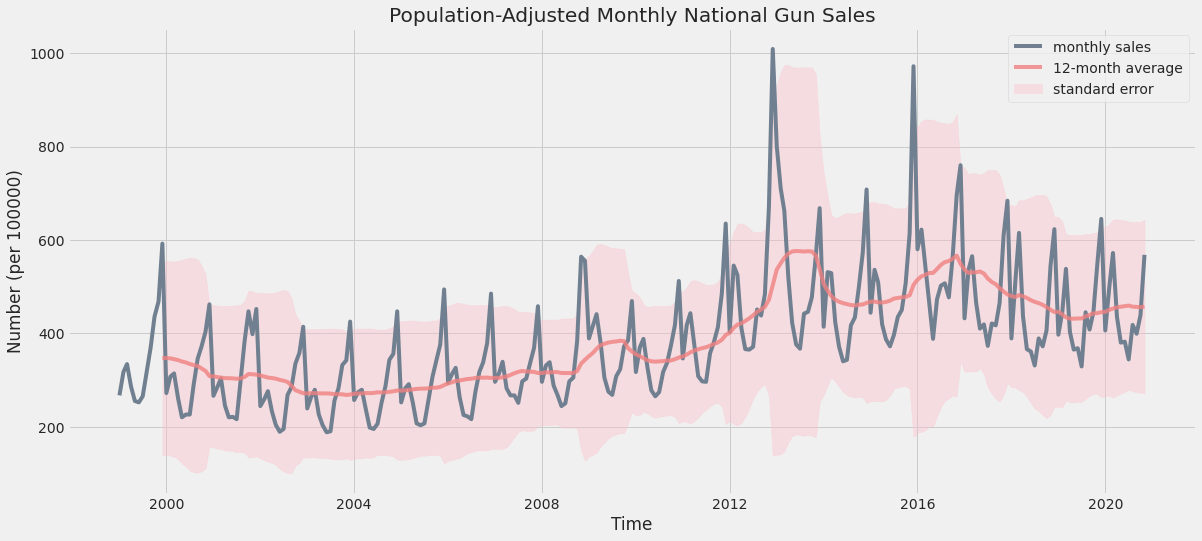

In [160]:
# Plot national total sales
style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=national_sales.index, y='total_sales_per_100000', data=national_sales, color='slategray',ax=ax, label='monthly sales')

rolling_national_sales = national_sales.rolling(12).mean()
sns.lineplot(x=national_sales.index, 
             y='total_sales_per_100000', 
             data=rolling_national_sales, 
             color='lightcoral',
             ax=ax, 
             label='12-month average', 
             alpha=0.8)

rolling_std = national_sales['total_sales_per_100000'].rolling(12).std().to_frame()
ax.fill_between(national_sales.index, 
                rolling_national_sales['total_sales_per_100000'] + (2 * rolling_std['total_sales_per_100000']), 
                rolling_national_sales['total_sales_per_100000'] - (2 * rolling_std['total_sales_per_100000']), 
                color='pink', alpha=0.4, 
                label="standard error")

ax.set(title='Population-Adjusted Monthly National Gun Sales', xlabel='Time', ylabel='Number (per 100000)')
ax.ticklabel_format(style='plain', axis='y') #Removes scientific notation (e.g., e^6 on y axis)
ax.legend()
#plt.savefig(f'../gun_sales_time_series/sales_per_100000_2020_adjusted.png', dpi=400, bbox_inches='tight')

We see now that the trend in 2020 doesn't have such a dramatic uptick. 

## 5.4.1. Autocorrelation

In [161]:
# Calcuate monthly change in price
monthly_diff = national_sales['total_sales_per_100000'].diff()

# Calculate and print the autocorrelation lag 1 of monthly changes.
guns_autocorrelation_monthly = monthly_diff.autocorr()
print("The autocorrelation of monthly gun sale changes is %4.2f" %(guns_autocorrelation_monthly))

The autocorrelation of monthly gun sale changes is -0.19


In [162]:
# Convert the monthly data to annual data using .resample
guns_yearly = national_sales.resample(rule='A').last()

# Calculate and print the autocorrelation lag 1 of yearly changes
guns_yearly_diff = guns_yearly.diff()
guns_autocorrelation_yearly = guns_yearly_diff['total_sales_per_100000'].autocorr()
print("The autocorrelation of annual gun sale changes is %4.2f" %(guns_autocorrelation_yearly))

The autocorrelation of annual gun sale changes is -0.30


The negative first-order autocorrelation indicates that absolute gun sales and changes in gun sales are mean-reverting. 

## 5.4.2. Autocorrelation Function (ACF)

In [163]:
# We're using the acf function and plotting below. Since we calculated diff, let's remove the NaN values so functions and plots will work properly
monthly_diff.dropna(inplace=True)

# Calculate acf
guns_monthly_acf = acf(monthly_diff)
guns_monthly_acf

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        , -0.19308915, -0.1172378 ,  0.11332263,  0.00468092,
       -0.2448839 , -0.08261554, -0.24622859,  0.0107712 ,  0.12147035,
       -0.08977849, -0.15765093,  0.80523206, -0.19682351, -0.0879548 ,
        0.13824743,  0.00757841, -0.21456733, -0.09073169, -0.25015895,
        0.02823807,  0.11217734, -0.0832052 , -0.14684962,  0.7477331 ,
       -0.18784966, -0.07227242,  0.13853174,  0.00451505, -0.20495947,
       -0.08616004, -0.23389998,  0.02946726,  0.07832086, -0.09835867,
       -0.11081977,  0.7069671 , -0.16151693, -0.07339888,  0.13398996,
        0.00291342])

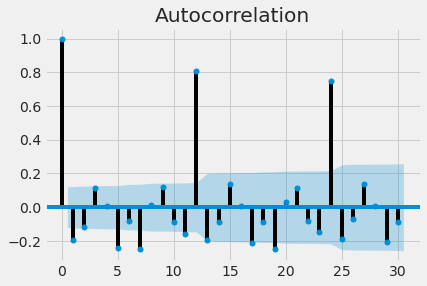

In [164]:
# Plot the acf function
plot_acf(monthly_diff, lags=30, alpha=0.05)
plt.show()
#plt.savefig(f'../gun_sales_time_series/acf_sales.png', dpi=400, bbox_inches='tight')

There's a clear negative autocorrelation with a 1 month lag and intermittent autocorrelations beyond that using a confidence level of 95% (alpha=0.5).

The strong positive autocorrelation every 12 months illustrates the seasonality we saw before

In [165]:
# We're using the acf function and plotting below. Since we calculated diff, let's remove the NaN values so functions and plots will work properly
guns_yearly_diff.dropna(inplace=True)

# Calculate acf
guns_yearly_acf = acf(guns_yearly_diff['total_sales_per_100000'])
guns_yearly_acf

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        , -0.29196856, -0.2594579 ,  0.27794451,  0.129675  ,
       -0.20877088, -0.13750746,  0.21684614, -0.15635432, -0.00597871,
       -0.04192217,  0.0012057 , -0.13438188,  0.06363288, -0.0010412 ,
       -0.07516295,  0.0643169 ,  0.01891772,  0.0232002 , -0.00520172,
        0.0220087 ])

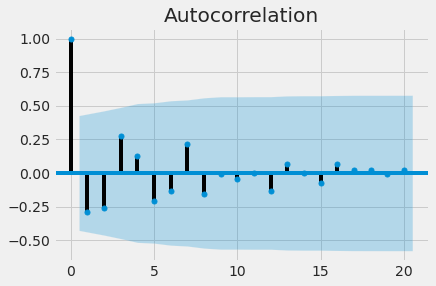

In [166]:
# Plot the acf function
plot_acf(guns_yearly_diff['total_sales_per_100000'], lags=20, alpha=0.05)
plt.show()
#plt.savefig(f'../gun_sales_time_series/acf_diff.png', dpi=400, bbox_inches='tight')

With a confidence level to 95% (alpha=0.5), in the long term, there is no clear autocorrelation either positive or negative outside of our confidence band so we cannot reject the null hypothesis that there is no autocorrelation between annual banana prices. Looking at autocorrelation alone, it's not possible to forecast gun sales 1 year out.

## 5.4.3. AD Fuller (ADF) Test

The ADF test results includes:
- test statistic
- p value
- critical values at 1%, 5%, and 10% confidence intervals

In [167]:
# ADF test on gun sales. 
guns_results = adfuller(national_sales['total_sales_per_100000'])
guns_results

(-1.172005630722171,
 0.685520794903931,
 13,
 249,
 {'1%': -3.4568881317725864,
  '5%': -2.8732185133016057,
  '10%': -2.5729936189738876},
 2597.977151356957)

In [168]:
# Print just the p value, which is index value 1
print('The p-value of the AD Fuller test for sales is: ' + str(guns_results[1]))

The p-value of the AD Fuller test for sales is: 0.685520794903931


The p value is above 0.05 and we cannot reject the null hypothesis that gun sales are a random walk.

In [169]:
# ADF test on gun sales changes. 
guns_diff_results = adfuller(monthly_diff)
guns_diff_results

(-5.92403143796278,
 2.4678439274491104e-07,
 12,
 249,
 {'1%': -3.4568881317725864,
  '5%': -2.8732185133016057,
  '10%': -2.5729936189738876},
 2587.9410568918925)

In [170]:
print('The p-value of the AD Fuller test for sales change is: ' + str(guns_diff_results[1]))

The p-value of the AD Fuller test for sales change is: 2.4678439274491104e-07


The p value is well below 0.05 and we can reject the null hypothesis that gun sales changes are a random walk.

In [171]:
guns_log = np.log(national_sales['total_sales_per_100000']/national_sales['total_sales_per_100000'].shift(1)).dropna()
guns_log_results = adfuller(guns_log)
guns_log_results

(-5.152430788710173,
 1.0986581077302779e-05,
 11,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 -497.3954135507548)

In [172]:
print('The p-value of the AD Fuller test for log of sales change is: ' + str(guns_log_results[1]))

The p-value of the AD Fuller test for log of sales change is: 1.0986581077302779e-05


The differenced data has a smaller p-value and more negative t-statistic than the log-transformed data so differencing works better here for statiorizing the data. 

### Box-Jenkins Framework

## 6. Identification

## 6.1. Seasonality

We can use the method seasonal_decompose from statsmodels.tsa.seasonal to decompose the daily data. This method is based on moving averages.

The steps inside of this function are:
- we first undercover global trend using Moving average
- we de-trend our data by substituding the trend values from the original data
- then we estimate seasonal component by taking averages of each season's value - for example, the effect of January is the average of all de-trended January values in the data

Let's check for seasonality and trend in the data using seasonal_decompose to decompose the observations in to observed, trend (moving average), seasonal, and noise. Let's set the model to additive in which the behavior is linear and changes over time are consitently the same amount: 

y(t) = Level + Trend + Seasonality + Noise

The other option would be to set the model to multiplicative where seasonality increases or decreases with the trend following a non-linear exponential or quadratic trend:

y(t) = Level x Trend x Seasonality x Noise

In reality, the trend is more likely a mix of both and, in fact, we actually did notice a changing amplitude with seasonality increasing in more recent years. Here we choose additive because the ADF test above suggested that a changing mean (additive) rathaer than changing variance (multiplicative) was the more dominant underlying trend. 

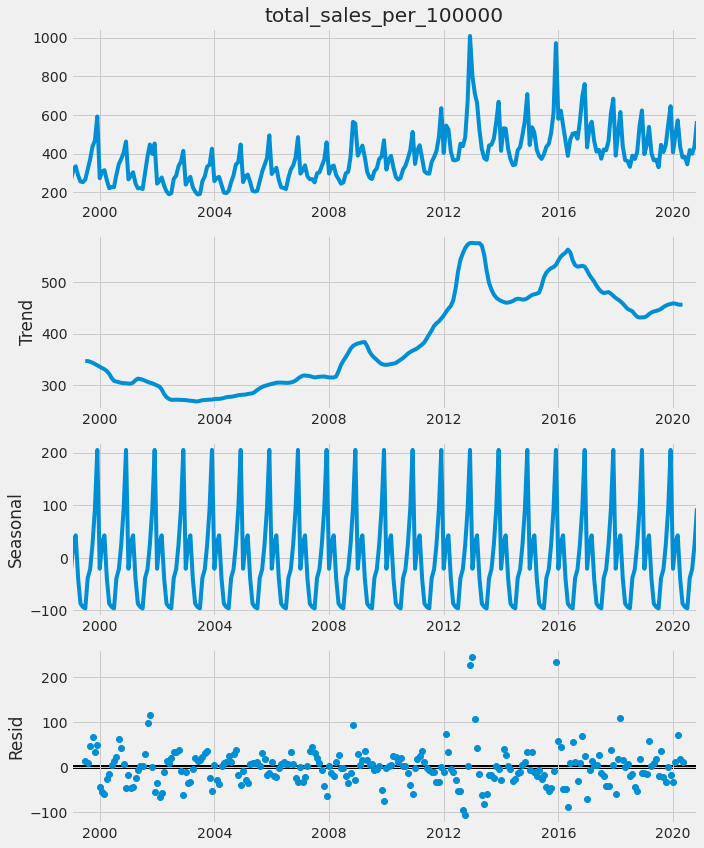

In [173]:
# Decompose banana prices
decompose = seasonal_decompose(national_sales['total_sales_per_100000'], model='additive', period=12)

# Plot decomposition
plt.rcParams["figure.figsize"] = [10,12]
decompose.plot()
plt.show()
#plt.savefig(f'../gun_sales_time_series/decompose.png', dpi=400, bbox_inches='tight')

Residuals in over the past decade are larger, mainly because the decompose method uses moving average and assumes the seasonal component repeats yearly and over-smooths the small, rapid rises and falls in gun sales since 2012 (this method is not robust to outlier values). Let's try another more flexible method - [Seasonal and Trend Decomposition using Loess (STL)](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html), which allows the user to control for the trend cycle and the rate at which seasonality changes.

In [174]:
guns_stl = pd.Series(national_sales['total_sales_per_100000'].values, index=pd.date_range('1999-1-1', periods=len(national_sales['total_sales_per_100000']), freq='M'))

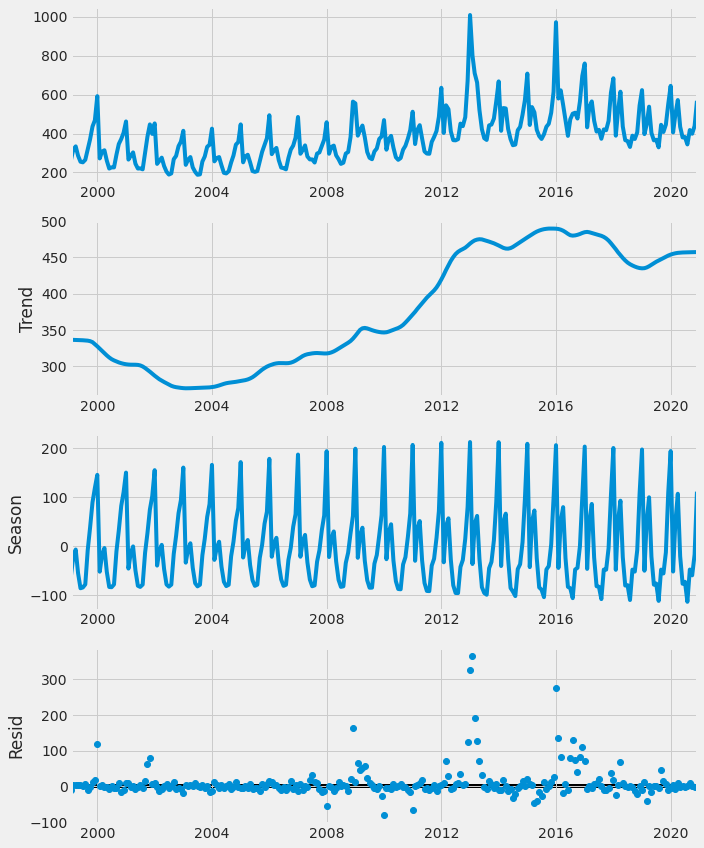

In [175]:
plt.rcParams["figure.figsize"] = [10,12]
stl = STL(guns_stl, seasonal=13, seasonal_deg=1, trend_deg=0, low_pass_deg=0, robust=True)
res = stl.fit()
fig = res.plot()
#plt.savefig(f'../gun_sales_time_series/stl_decompose.png', dpi=400, bbox_inches='tight')

With STL, the trend is different from classical decompose - we more clearly see the structural uptick in 2012 - and the seasonality increases over time rather than repeating every year. The residuals look better for most of the time period, but are still not robust to the significant outliers in 2013 and 2016, for example. 

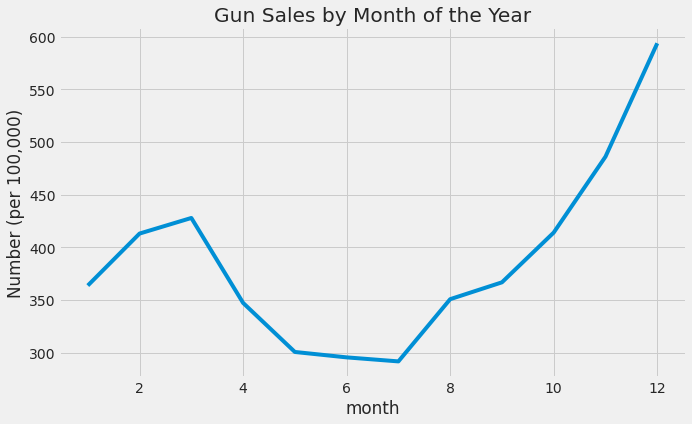

In [176]:
# Group mean sales by month
guns_month = national_sales.groupby('month').mean()

# Plot banana prices by month of the year
plt.figure(figsize=(10,6))
guns_month['total_sales_per_100000'].plot(title = 'Gun Sales by Month of the Year')
plt.ylabel('Number (per 100,000)')
plt.show()
#plt.savefig(f'../gun_sales_time_series/guns_seasonal.png', dpi=400, bbox_inches='tight')

We see again the clear seasonality with the uptick in December. Let's plot an acf to further check seasonality. Before we do that, it's important to detrend the data by subtracting the rolling mean to make the seasonality in the acf plot clearer.

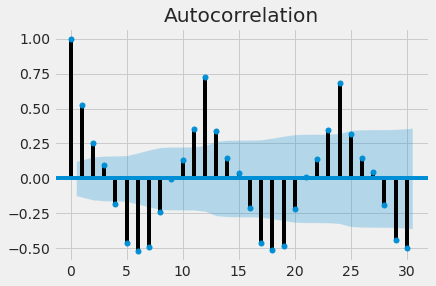

In [177]:
# Detrend gun sales by subtracting the rolling mean of 12 months 
guns_detrend = national_sales['total_sales_per_100000'] - national_sales['total_sales_per_100000'].rolling(12).mean()
guns_detrend.dropna(inplace=True)

# Plot acf of detrended data
plt.rcParams["figure.figsize"] = [6,4]
plot_acf(guns_detrend, lags=30, alpha=0.05)
plt.show()
#plt.savefig(f'../gun_sales_time_series/acf_detrend.png', dpi=400, bbox_inches='tight')

The acf plot of the detrended data illustrates a seasonality of 12 months with the sigfnicant negative and positive autocorrelations every 12 months.

## 6.2. Stationarize

In order to use our data to make predictions, it's important to transform the data to make it stationary - that is, removing any trend that the series has (e.g., seasonal, upward, etc) so that it has a constant mean and variance and that the autocovariance between two points doesn't depend on time. We know that our data is non-stationary because changes in gun sales (.diff) do not follow a random walk as the ADF test has a low p-value. Transformations such as log transform help to stabilize variance (e.g., with multiplicative seasonality), while n-order and seasonal differencing help to stabilize mean.

1) Seasonal differencing of 12 months.

2) N-order differencing on the seasonally adjusted data to stabilize the mean, which shows an upward trend.

In [178]:
# Seasonally adjusted series
guns_adjusted = national_sales['total_sales_per_100000'].diff(12)

# 1st order differencing on seasonally adjusted data
guns_diff_1 = guns_adjusted.diff()
guns_diff_1.dropna(inplace=True)

# 2nd order differencing on seasonally adjusted data
guns_diff_2 = guns_adjusted.diff().diff()
guns_diff_2.dropna(inplace=True)

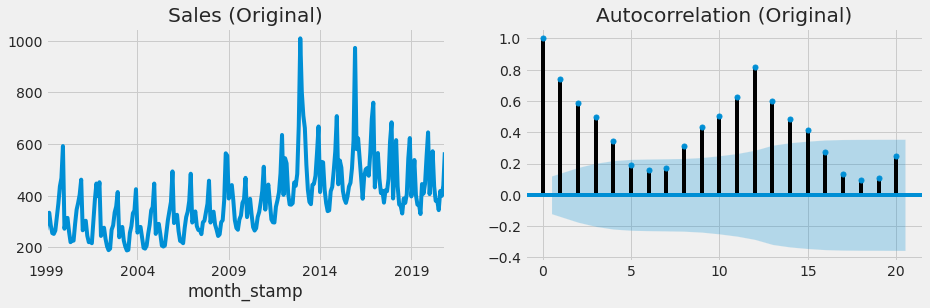

In [179]:
# Plot original sales and autocorrelation
fig = plt.figure() 

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Subplot 1: 1st Order Differencing
national_sales['total_sales_per_100000'].plot(figsize=(14, 4), ax=ax0)
ax0.set_title('Sales (Original)')

# Subplot 2: Autocorrelation (Original)
plot_acf(national_sales['total_sales_per_100000'], lags=20, ax=ax1) 
ax1.set_title ('Autocorrelation (Original)')

plt.show()
#plt.savefig(f'../gun_sales_time_series/sales_acf.png', dpi=400, bbox_inches='tight')

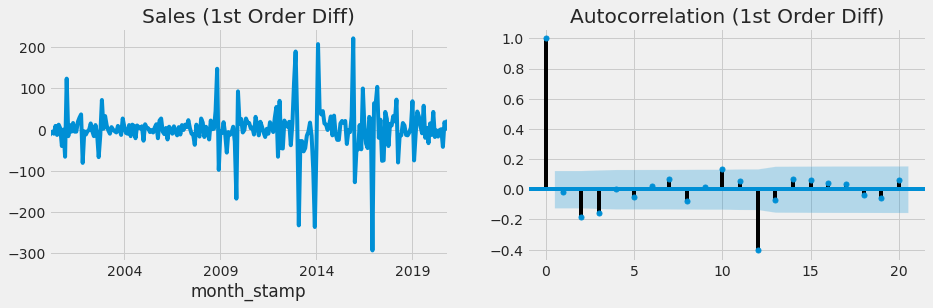

In [180]:
# Plot 1st order diff sales and autocorrelation
fig = plt.figure() 

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Subplot 1: 1st Order Differencing
guns_diff_1.plot(figsize=(14, 4), ax=ax0) 
ax0.set_title('Sales (1st Order Diff)')

# Subplot 2: Autocorrelation
plot_acf(guns_diff_1, lags=20, ax=ax1) 
ax1.set_title ('Autocorrelation (1st Order Diff)')

plt.show()
#plt.savefig(f'../gun_sales_time_series/1st_diff.png', dpi=400, bbox_inches='tight')

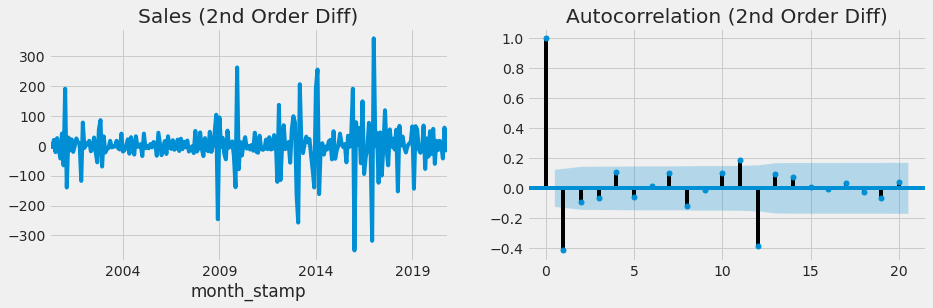

In [181]:
# Plot 2nd order diff sales and autocorrelation
fig = plt.figure() 

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Subplot 1: 2nd Order Differencing
guns_diff_2.plot(figsize=(14, 4), ax=ax0) 
ax0.set_title('Sales (2nd Order Diff)')

# Subplot 2: Autocorrelation
plot_acf(guns_diff_2, lags=20, ax=ax1) 
ax1.set_title ('Autocorrelation (2nd Order Diff)')

plt.show()
#plt.savefig(f'../gun_sales_time_series/2nd_diff.png', dpi=400, bbox_inches='tight')

While it looks like the 2nd order differencing gets us a bit closer to stationarity, its autocorrelation plot goes steeply negative right away at lag 1, meaning that this is likely overdifferenced. As a result, let's stick with the 1st order differencing even though it's not perfect (weakly stationary) (we can see that it's not perfectly stationary as the variance in the plot decreases over time). Using 1st order differencing means that the 'd' value for the SARIMAX model later is 1.

Let's check that the 1st order diff is stationary by running an ADF test. The null hypothesis is that there is a unit root for a series while the alternative is that it's stationary. If the p value is less than 0.05 (at 95% confidence), then we can reject the null and accept the alternative that the series is stationary. 

In [182]:
# Check that 1st order diff is stationary by running AD Fuller test.  
guns_diff_1_results = adfuller(guns_diff_1)

print('The p-value of the ADF test is: ' + str(guns_diff_1_results[1]))

The p-value of the ADF test is: 1.1964130541237838e-08


The p-value is tiny indicating our series is stationary.

## 6.3. Identify AR Order

Let's determine the order, or optimal lag length, of the AR (autoregressive) model by two methods: 1) partial autocorreation (PACF) and 2) information / goodness-of-fit criteria, specifically Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC). AIC and BIC both aim to simplify the model by penalizing overly complex (excessive orders) models. The goal is to minimize the AIC and BIC values. They often favor the same model, but, when they don't, you can choose the lowest AIC if you're looking for a better predictive model and BIC if you're looking for a better explanatory model.

PACF determines the incremental benefit of adding another lag. In a PACF plot, the number of significant lags indicates the order of the AR model. 

## 6.3.1. Partial ACF (PACF)

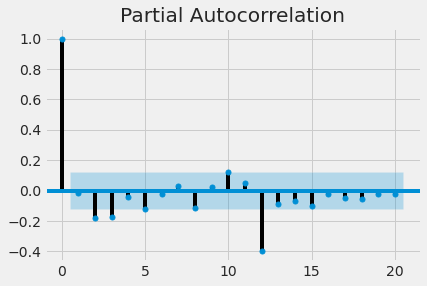

In [183]:
# PACF plot
plt.rcParams["figure.figsize"] = [6,4]
plot_pacf(guns_diff_1, lags=20)
plt.show()
#plt.savefig(f'../gun_sales_time_series/pacf.png', dpi=400, bbox_inches='tight')

From our PACF plot, it looks like there are 3 lags that is statistically significant. However, to be on the conservative side and avoid overfitting, let's select 2 a 'p' values for our SARIMAX model. 

## 6.3.2. AIC and BIC

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information wa

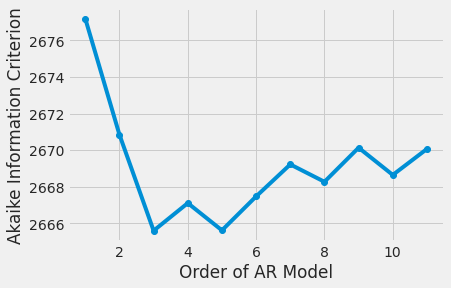

In [184]:
# Fit the data to an AR(p) for p = 0,...,12 , and save the AIC
AIC = np.zeros(12)
for p in range(12):
    mod = ARMA(guns_diff_1, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    AIC[p] = res.aic
    
# Plot the AIC as a function of p
plt.figure(figsize=(6,4))
plt.plot(range(1,12), AIC[1:12], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()
#plt.savefig(f'../gun_sales_time_series/aic.png', dpi=400, bbox_inches='tight')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information wa

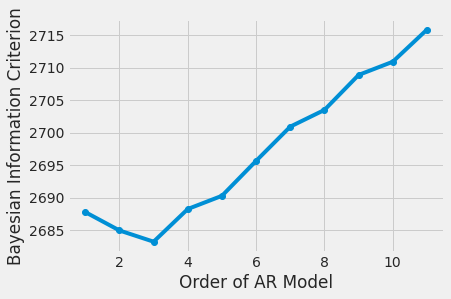

In [185]:
# Fit the data to an AR(p) for p = 0,...,12 , and save the BIC
BIC = np.zeros(12)
for p in range(12):
    mod = ARMA(guns_diff_1, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.figure(figsize=(6,4))
plt.plot(range(1,12), BIC[1:12], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()
#plt.savefig(f'../gun_sales_time_series/bic.png', dpi=400, bbox_inches='tight')

While, the AIC and BIC in the plots above are also lowest at 3 lags, to be on the convservative side and avoid overfitting, let's select 2. 

The PACF plot, AIC, and BIC support a 'p' value for the SARIMAX model later is 2.

In [186]:
# Full summary of AR model (AIC, BIC values below, coefficients (phi) for each order also below)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     total_sales_per_100000   No. Observations:                  250
Model:                        ARMA(11, 0)   Log Likelihood               -1322.031
Method:                           css-mle   S.D. of innovations             47.856
Date:                    Tue, 15 Dec 2020   AIC                           2670.062
Time:                            11:56:10   BIC                           2715.841
Sample:                        02-01-2000   HQIC                          2688.487
                             - 11-01-2020                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0075      2.054      0.004      0.997      -4.017       4.032
ar.L1.total_sales_per_100000     -0.0677      0.063     -1.073      0.283      -0.191       0.056
ar.L2.total_sales_per_100000     -0.2011      0.063     -3.211      0.001      -0.324      -0.078
ar.L3.total_sales_per_100000     -0.2068      0.064     -3.242      0.001      -0.332      -0.082
ar.L4.total_sales_per_100000     -0.0498      0.065     -0.766      0.444      -0.177       0.078
ar.L5.total_sales_per_100000     -0.1140      0.065     -1.764      0.078      -0.241       0.013
ar.L6.total_sales_per_100000     -0.0278      0.065     -0.427      0.670      -0.155       0.100
ar.L7.total_sales_per_100000      0.0562      0.065      0.871      0.384      -0.070       0.183
ar.L8.total_sales_per_100000     -0.0701      0.064     -1.086      0.277      -0.196       0.056
ar.L9.total_sales_per_100000      0.0397      0.063      0.626      0.532      -0.085       0.164
ar.L10.total_sales_per_100000     0.1190      0.062      1.920      0.055      -0.002       0.240
ar.L11.total_sales_per_100000     0.0476      0.063      0.761      0.447      -0.075       0.170
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.2931           -0.0000j            1.2931           -0.0000
AR.2             0.9096           -0.7370j            1.1707           -0.1084
AR.3             0.9096           +0.7370j            1.1707            0.1084
AR.4             0.4062           -1.0961j            1.1689           -0.1935
AR.5             0.4062           +1.0961j            1.1689            0.1935
AR.6            -0.3178           -1.1304j            1.1742           -0.2936
AR.7            -0.3178           +1.1304j            1.1742            0.2936
AR.8            -1.3443           -0.7024j            1.5168           -0.4234
AR.9            -1.3443           +0.7024j            1.5168            0.4234
AR.10           -1.5503           -0.5765j            1.6540           -0.4433
AR.11           -1.5503           +0.5765j            1.6540            0.4433
------------------------------------------------------------------------------
"""

Notice that in the summary, the AR(2) coefficient is highest in absolute terms and has a p-value ('P>z') of nearly 0, while many of the other coefficients are closer to 0 and have higher p-values, further supporting our AR(2) selection. 

## 6.4. Identify MA Order

Similar to how we used PACF of the 1st order differenced data to determine the AR model, we can use the ACF of the 1st order differenced data to determine the MA (moving average) as MA is essentially the error of the lagged forecast. The number of significant lags is the number of MA terms needed to remove autocorrelation in the staionary data.

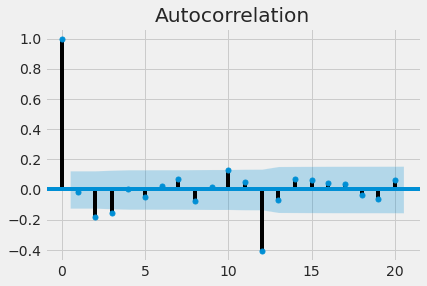

In [187]:
# ACF plot of 1st order differenced sales
plt.rcParams["figure.figsize"] = [6,4]
plot_acf(guns_diff_1, lags=20)
plt.show()
#plt.savefig(f'../gun_sales_time_series/acf_ma.png', dpi=400, bbox_inches='tight')

From our ACF plot, 2 lags look significant, but one of them is close to the 95% confidence band and let's actually stay on the conservative side to avoid overfitting and go with a 'q' value for the SARIMAX model later of 1. 

Note: If we believe the series is slightly under-differenced, we could add one or two more AR terms to make it up. Similarly, if we think the data is slightly over-differenced, we could add one or two more MA terms to make it up.

## 7. Estimation

## 7.1. SARIMA

Since our data has seasonality, we'll use a SARIMA and SARIMAX model (Seasonal Autoregressive Integrated Moving Average). If we fit a simple ARIMA model, we would have correlated residuals left, meaning we wouldn't be using all the information in the data. 

Let's review what we got for the order (p,d,q) for the model 
- p: PACF plot, AIC, and BIC supports a 'p' value for the SARIMAX model of 2
- d: 1st order differencing plot supports a 'd' value for the SARIMAX model of 1
- q: ACF plot of differenced series supports a'q' value for the SARIMAX model of 1

We have an order(p,d,q) as order=(2,1,1) for the ARIMA component. 

For the the seasonal component P, D, Q, let's use auto_arima from pyramid-arima to automatically perform a grid search for p, d, q, P, D, Q values based on AIC and BIC scores. 

In [188]:
# Instantiate SARIMA model
sarima = auto_arima(national_sales['total_sales_per_100000'], start_p=0, start_q=1,max_p=4, max_q=2, m=12,
                           start_P=0, start_Q=0, max_P=2, max_Q=2, seasonal=True, d=1, D=1, trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)
# Summary of results
sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2675.150, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2673.256, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2632.044, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2597.283, Time=0.36 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2598.682, Time=0.61 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2598.550, Time=1.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2631.949, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2598.636, Time=6.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2596.957, Time=0.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2598.129, Time=0.45 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2598.003, Time=1.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=2630.234, Time=0.10 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=2598.587, Time=3.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2597.780, Time=0.37 sec
 ARIMA(1,1,1)(0,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  263
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1285.847
Date:                            Tue, 15 Dec 2020   AIC                           2579.693
Time:                                    11:56:40   BIC                           2593.779
Sample:                                         0   HQIC                          2585.362
                                            - 263                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7461      0.047     15.723      0.000       0.653       0.839
ma.L1         -0.9496      0.030    -31.335      0.000      -1.009      -0.890
ma.S.L12      -0.6548      0.031    -21.455      0.000      -0.715      -0.595
sigma2      1663.4794     62.505     26.613      0.000    1540.971    1785.988
===================================================================================
Ljung-Box (Q):                       43.99   Jarque-Bera (JB):              1482.88
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               4.90   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Interestingly, the optimal model generated is slightly different from ours at SARIMA(1,1,1)x(0,1,1,12) with an AIC of 2592 and a BIC of 2606.

## 7.2. SARIMAX

SARIMAX can do everything that ARMA, ARMAX, ARIMA, and SARIMA models can do and more, while also incorporating exogenous variables (e.g., other data that could affect gun sales could be unemployment, poverty, crime rates, legistlation, etc), though we won't be featuring exogenous variables here.

In [189]:
df_sarimax = national_sales[['total_sales_per_100000']]

# Instantiate SARIMAX model with the optimal orders we generated above. Include trend='c' as our mean is not centered around zero
best_model = SARIMAX(df_sarimax['total_sales_per_100000'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), trend='c')

# Fit SARIMAX model
results=best_model.fit()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## 8. Model Diagnostics

## 8.1. Plot Diagnostics

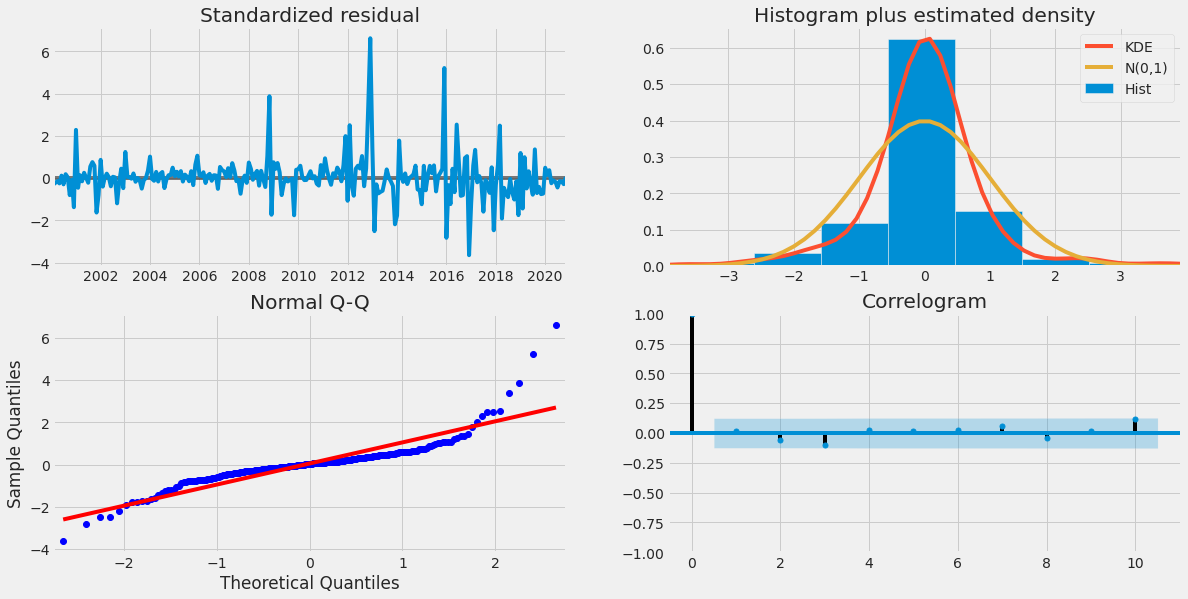

In [190]:
# Plot diagnostics 
results.plot_diagnostics(figsize=(18, 9))
plt.show()
#plt.savefig(f'../gun_sales_time_series/plot_diagnostics.png', dpi=400, bbox_inches='tight')

The plot of the model's diagnostics illustrate what we should expect from the residuals:

1) Standardized residual shows no obvious pattern (though we do see significant variability in more recent months)
<br>2) The model distribution (red) deviates somewhat from a normal distribution (yellow)
<br>3) The normal QQ plot illustrates how close the distribution of the residuals compares to that of a normal distribution. Most points on the QQ plot lie close to the line, though there is some curvature and notably stronger correlations on the higher end
<br>4) In the correlogram (an ACF plot of the residuals), >95% of the correlations are not significant, meaning that we're using all the information in the data.

## 8.2. SARIMAX Summary

In [191]:
# Summary of SARIMAX results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             total_sales_per_100000   No. Observations:                  263
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1286.846
Date:                            Tue, 15 Dec 2020   AIC                           2583.693
Time:                                    11:56:42   BIC                           2601.300
Sample:                                01-01-1999   HQIC                          2590.779
                                     - 11-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.030      0.039      0.969      -0.059       0.061
ar.L1          0.8176      0.034     24.257      0.000       0.752       0.884
ma.L1         -0.9981      0.122     -8.149      0.000      -1.238      -0.758
ma.S.L12      -0.6281      0.036    -17.579      0.000      -0.698      -0.558
sigma2      1661.5795    185.531      8.956      0.000    1297.946    2025.213
===================================================================================
Ljung-Box (Q):                       45.17   Jarque-Bera (JB):              1463.31
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               4.90   Skew:                             1.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the summary above, the Ljung Box(Q) test and its p-value Prob(Q) features the null hypothesis that the residuals are uncorrelated. If Prob(Q) is above 0.05, we can accept the null hypothesis that there are no correlations in the residual. If Prob(Q) is below 0.05, we reject the null hypothesis, meaning that there are correlations among residuals. The Jarque-Bera(JB) test and its p-value Prob(JB) features the null hypothesis that the residuals are normally distributed. If Prob(JB) is above 0.05, we can accept the null hypothesis that the residuals are normally distributed. If Prob(JB) is below 0.05, we reject the null hypothesis, meaning that residuals are not normally distibuted.

- We have fairly strong p-value for the MA coefficient
- Prob(Q) is above 0.05, indicating there are no correlations in the residual
- Prob(JB) is below 0.05 indicating that the residuals are not normally distributed. This is an area of improvement we can look into in the future

## 8.3. Prediction (In-Sample)

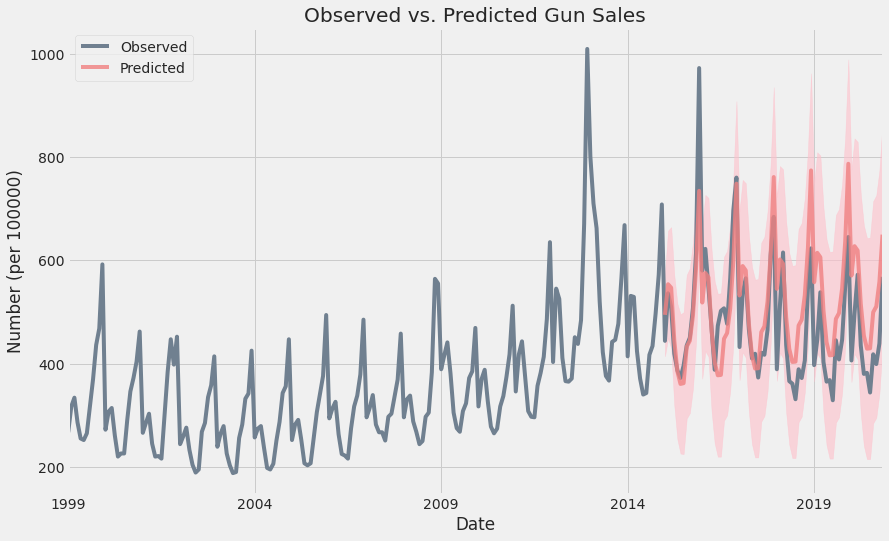

In [192]:
# Use SARIMAX model to predict gun sales from 2015 onward. Set dynamic to True to cncorporated predicted values (not just true endogenous values) into prediction
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True) 

# Variable for confidence interval using .conf_int()
pred_ci = pred.conf_int()

# Plot

ax = df_sarimax['1999':].plot(label='Observed', color='slategray')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.8, figsize=(13, 8), color='lightcoral')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='pink', alpha=.6)
ax.set_xlabel('Date')
ax.set_ylabel('Number (per 100000)')
plt.title('Observed vs. Predicted Gun Sales')
plt.legend(loc='upper left', labels=['Observed','Predicted'])
plt.show()
#plt.savefig(f'../gun_sales_time_series/predicted.png', dpi=400, bbox_inches='tight')

In the prediction, we can see that our model is overshooting in the 2018, 2019, 2020. 

## 8.3.1. Evaluation

In [193]:
# Mean of prediction and observed from 2015 to current
y_predicted = pred.predicted_mean
y_observed = df_sarimax['2015-01-01':]

# Calculate evaluation metrics
mse = mean_squared_error(y_observed,y_predicted)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_observed,y_predicted)

# Since MAPE isn't in scikitlearn, let's define it
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Print evaluation metrics
print('The Mean Squared Error (MSE) is {}'.format(mse))
print('The Root Mean Squared Error (RMSE) is {}'.format(rmse))
print('The Mean Absolute Error (MAE) is {}'.format(mae))
print('The Mean Absolute Percentage Error (MAPE) is {}'.format(mape(y_observed, y_predicted)))

The Mean Squared Error (MSE) is 6901.4829171145775
The Root Mean Squared Error (RMSE) is 83.07516426173696
The Mean Absolute Error (MAE) is 67.3156942324478
The Mean Absolute Percentage Error (MAPE) is 26.244011060895538


MAPE is the most useful in evaluating the quality of the model. MAPE indicates that the average difference between the predicted value from the model and the historical observed value is roughly 26%. 

## 8.4. Forecast (Out-of-Sample)

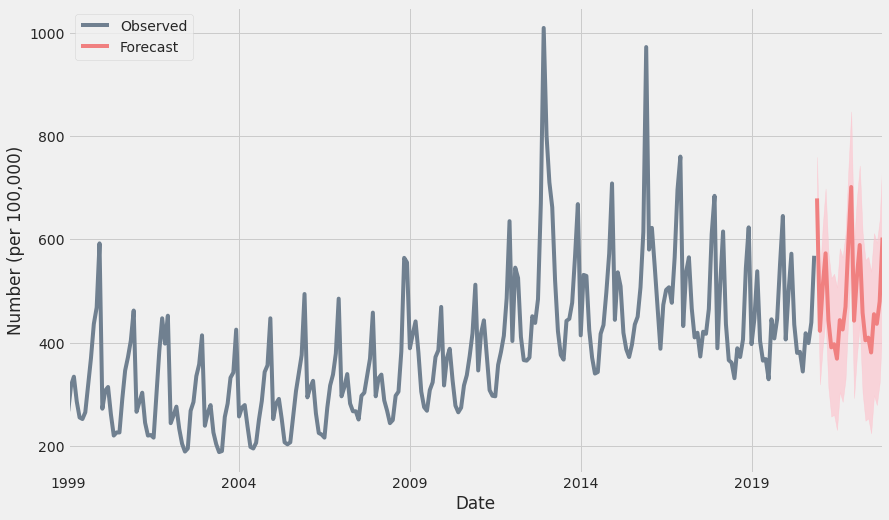

In [194]:
# Use SARIMAX model to forecast gun sales for the next 24 months
forecast = results.get_forecast(steps=24, dynamic=True)

# Variable for confidence interval using .conf_int()
forecast_ci = forecast.conf_int()

# Plot
ax = df_sarimax['total_sales_per_100000'].plot(label='Observed', figsize=(13, 8), color='slategray')
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='lightcoral')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=.6)
ax.set_xlabel('Date')
ax.set_ylabel('Number (per 100,000)')
plt.legend(loc='upper left', labels=['Observed','Forecast'])
plt.show()
#plt.savefig(f'../gun_sales_time_series/forecast.png', dpi=400, bbox_inches='tight')

In the future, we could revisit our SARIMAX model parameters. Additionally, in order to better evaluate, we should get context and appropriate errors and metrics from policy experts to understand what works best. Additionally, as MAPE has its own disadvantages, we could explore other evaluation criteria.

In [195]:
# Forecasted gun sales per 100,000 for the next 12 months
y_forecasted = pd.DataFrame(forecast.predicted_mean.astype(int), columns = ['total_sales_per_100000'])
y_forecasted.head(12)

total_sales_per_100000
2020-12-01                     679
2021-01-01                     422
2021-02-01                     509
2021-03-01                     572
2021-04-01                     443
2021-05-01                     390
2021-06-01                     396
2021-07-01                     368
2021-08-01                     443
2021-09-01                     425
2021-10-01                     469
2021-11-01                     593

## 9. Future Areas for Improvement

**Long-gun vs. handgun**: we only dug into total sales of all types of guns, it would be interesting to understand state-level and national trends between long guns, which are traditionally bought more for hunting, and handguns, which are used more for self-defense 

**Context**: get more context from industry experts to understand what constitutes a reasonable forecast error in this specific case. MAPE has its own disadvantages so consider other metrics that social policy experts use

**Distribution of Residuals**: As we saw above with the Jarque-Bera(JB) test and its low (<0.05) p-value Prob(JB) that residuals are not entirely normally distributed. We could also see this in the QQ plot. We could check if removing more outliers improves this.

**Stationarity**: Our differenced data is only weakly stationary. We can see this in the higher variance in the earlier part of the series. Apply and compare other log transform, n-level differencing, seasonal differencing, or square root adjustments.

**Incorporate exogenous variables**: Incorporate exogenous variables (e.g., unemployment, poverty, crime rates, legistlation, covid, etc)) into SARIMAX.

**Social Policy**: Translate the model selection/optimization rationale, evaluation metrics (e.g., MAPE), predictions and forecasts into specific social policy impact so that it's helpful to understand for legilslators and the public.

## 10. Resources

[FBI NICS](https://www.fbi.gov/services/cjis/nics)

[Federal Reserve Economic Data(FRED)](https://fred.stlouisfed.org/)

[BuzzFeed gun background checks](https://github.com/BuzzFeedNews/nics-firearm-background-checks)

[BuzzFeed Gun Sales Git](https://github.com/BuzzFeedNews/2017-11-gun-sales-estimates/blob/master/data/popest.csv)

[NYT Gun Sales Git](https://github.com/nytimes/gunsales)

[Gun Sales Readme](https://cran.r-project.org/web/packages/gunsales/README.html)

[Small Arms Survey](http://www.smallarmssurvey.org/fileadmin/docs/F-Working-papers/SAS-WP14-US-Firearms-Industry.pdf)

[BuzzFeed Guns After Vegas Shooting](https://www.buzzfeednews.com/article/peteraldhous/gun-sales-after-vegas-shooting)

[Statsmodels STL Decomposition](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html)

[Berlin Time Series Analysis meetup git](https://github.com/Anna-Barnett/btsa/tree/master/python/fundamentals/notebooks)

[Intro to ML with Time Series mlonging git](https://github.com/mloning/intro-to-ml-with-time-series-DSSGx-2020/blob/master/notebooks/02_exploratory_data_analysis.ipynb)

[Introduction to ARIMA](https://people.duke.edu/~rnau/411arim.htm)

[Seasonality Additive or Multiplicative](https://sigmundojr.medium.com/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7)

[Time Series Decomposition and Prediction in Python](https://pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/)

[Matplotlib boxpatch](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.FancyBboxPatch.html)

[Boxpatch example](https://github.com/DataForScience/Epidemiology101/blob/master/Epidemiology003.ipynb)

[Seaborn time series facets](https://seaborn.pydata.org/examples/timeseries_facets.html)